<a href="https://www.kaggle.com/code/minseo14/arc-task-00d62c1b-with-cnn?scriptVersionId=189971139" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ARC Task 00d62c1b with CNN!
> ### Models in this page are specialized only for the single data, 00d62c1b. 
> ### Still a necessary step though!

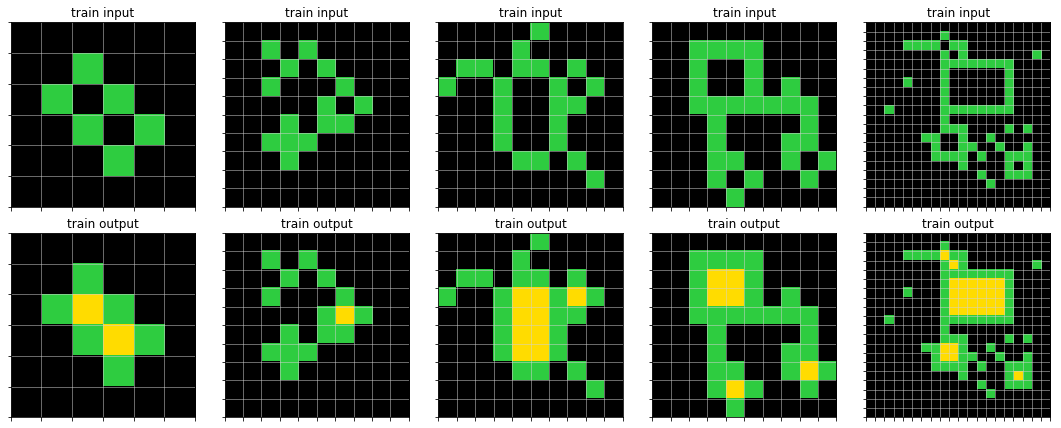

## Abastract
    CNNs seems have a limitation to detect all borders without long term memory.
### Next Step 
    Apply boundary fill algorithm from the border of the image detecting nearby pixels having the same color. 
    Then detect the significant rest pixels

### Extention (To aproach end-to-end)
    Classify whether the shape is stable or not.
    Predict what kind of pattern/roles each task/color has.
    
### Citation of code
> [Basic Attention Model - deep-learning-from-scratch-2](https://github.com/oreilly-japan/deep-learning-from-scratch-2/tree/master/ch08)

---

# Step 0: Setup

## 0-1. Install Libraries and Import Modules

> ### Add Path

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arcsourcecode/data.py
/kaggle/input/arcsourcecode/train.py
/kaggle/input/arcsourcecode/test.py
/kaggle/input/arcsourcecode/classify.py
/kaggle/input/arcsourcecode/2_00d62c1b.png
/kaggle/input/arcsourcecode/configs/train.yaml
/kaggle/input/arcsourcecode/configs/test.yaml
/kaggle/input/arcsourcecode/configs/model/FillerKeepInputIgnoreColor.yaml
/kaggle/input/arcsourcecode/configs/model/FillerKeepInput.yaml
/kaggle/input/arcsourcecode/configs/data/FillerKeepInput_test.yaml
/kaggle/input/arcsourcecode/configs/data/FillerKeepInput_train.yaml
/kaggle/input/arcsourcecode/configs/data/FillerKeepInputIgnoreColor_test.yaml
/kaggle/input/arcsourcecode/configs/data/FillerKeepInputIgnoreColor_train.yaml
/kaggle/input/arcsourcecode/configs/test/FillerKeepInputIgnoreColor.yaml
/kaggle/input/arcsourcecode/configs/test/FillerKeepInput.yaml
/kaggle/input/arcsourcecode/configs/train/FillerKeepInputIgnoreColor.yaml
/kaggle/input/arcsourcecode/configs/train/FillerKeepInput.yaml
/kaggle/input/

In [2]:
import sys
sys.path.insert(1, '/kaggle/input/arcsourcecode')

> ### Install Hydra

In [3]:
!pip install hydra-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.1 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=ac2e22c5f409431f3cb8efa50b3d494d93d447bc7e9a0a9b4f8f2e0f8c3be1c2
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


> ### Load Config Files and Train/Test Functions

In [4]:
from omegaconf import OmegaConf
import torch
from torch import nn

from train import train
from test import test

In [5]:
base_path = '/kaggle/input/arc-prize-2024/'
config_path = '/kaggle/input/arcsourcecode/configs/'

def load_config(path, config_path=config_path):
    return OmegaConf.load(config_path + path)

# Hyperparameters for Training
def load_train_config(ignore_color=False):
    if ignore_color:
        config_data = load_config("data/FillerKeepInputIgnoreColor_train.yaml")
        config_model = load_config("model/FillerKeepInputIgnoreColor.yaml")
        config_train = load_config("train/FillerKeepInputIgnoreColor.yaml")
        config_test = load_config("test/FillerKeepInputIgnoreColor.yaml")
    else:
        config_data = load_config("data/FillerKeepInput_train.yaml")
        config_model = load_config("model/FillerKeepInput.yaml")
        config_train = load_config("train/FillerKeepInput.yaml")
        config_test = load_config("test/FillerKeepInput.yaml")
        
    config_train = OmegaConf.merge({'data': config_data, 'model': config_model, 'train': config_train, 'test': config_test})
    config_train.data.params.base_path = '/kaggle/input/arc-prize-2024/'
    config_train.save_path = './output/'
    
    return config_train

# Hyperparameters for Testing
def load_test_config(train=False, ignore_color=False):
    if ignore_color:
        config_data = load_config("data/FillerKeepInputIgnoreColor_test.yaml")
        config_model = load_config("model/FillerKeepInputIgnoreColor.yaml")
        config_test = load_config("test/FillerKeepInputIgnoreColor.yaml")
    else:
        config_data = load_config("data/FillerKeepInput_test.yaml")
        config_model = load_config("model/FillerKeepInput.yaml")
        config_test = load_config("test/FillerKeepInput.yaml")
    
    config_test = OmegaConf.merge({'data': config_data, 'model': config_model, 'test': config_test})
    config_test.data.params.base_path = '/kaggle/input/arc-prize-2024/'
    
    return config_test

## 0-2. Data Augmentation (Rotation, Flipping)

Data size: 5

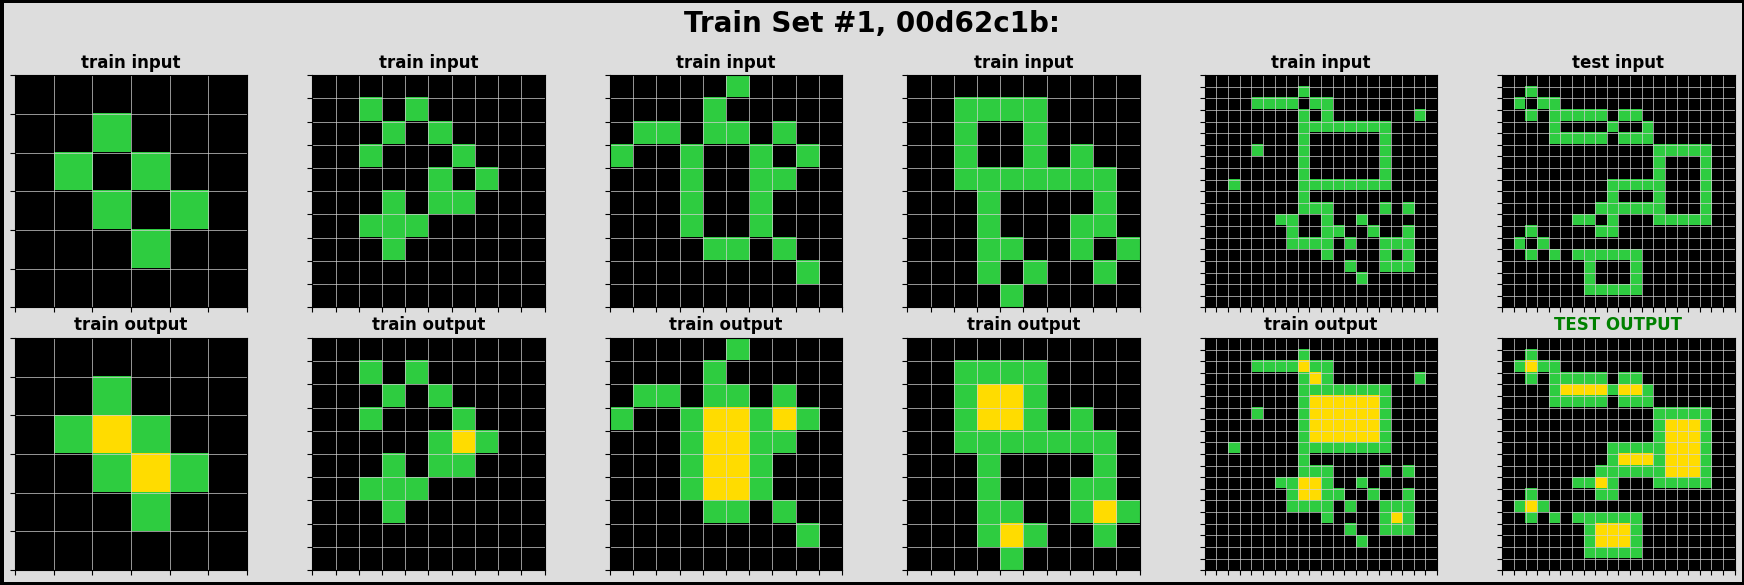

In [6]:
from rich import print
from data import ARCDataset
from arc_prize.constants import get_challenges_solutions_filepath
from arc_prize.utils.visualize import plot_task
from classify import ARCDataClassifier


data_category = 'train'
challenges, solutions = get_challenges_solutions_filepath(data_category, base_path)

# Filtering Dataset
filter_funcs = (
    ARCDataClassifier.in_data_codes_f(['00d62c1b']),
#     ARCDataClassifier.is_same_shape_f(True),
#     ARCDataClassifier.is_n_m_colored_in_out_f(2, 3),
#     ARCDataClassifier.is_dominent_color_stable_f(True),
)

dataset = ARCDataset(challenges, solutions, one_hot=False, filter_funcs=filter_funcs)
print(f'Data size: {len(dataset[0][0])}')

# Visualize a task
for index in range(len(dataset)):
    plot_task(dataset, index, data_category)
    break

Data size: 34

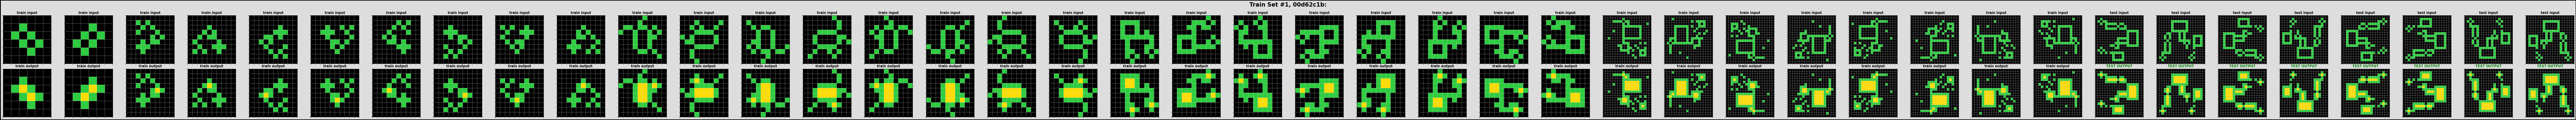

In [7]:
dataset = ARCDataset(challenges, solutions, one_hot=False, filter_funcs=filter_funcs, augment_data=True)
print(f'Data size: {len(dataset[0][0])}')

# Visualize a task
for index in range(len(dataset)):
    plot_task(dataset, index, data_category='Train')
    break

# Step 1: Consider which pixel to be substituted

## 1-1. Predict the positions to be substituted

In [8]:
config = load_train_config(ignore_color=True)
train(config)

data:
  name: FillerKeepInputIgnoreColor
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: true
    ignore_color: true
model:
  name: FillerKeepInputIgnoreColor
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
train:
  name: default
  params:
    max_epochs: 60
    batch_size_max: 8
    lr: 0.01
    save_dir: ./output/
    ckpt_path: null
test:
  name: default
  params:
    model_path: ./output/FillerKeepInputIgnoreColor.ckpt
    verbose_single: false
save_path: ./output/

FillerKeepInputIgnoreColorL(
  (model): FillerKeepInputIgnoreColor(
    (feature_extractor): ConvFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=32, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (decoder): Conv2dEncoderLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=32, out_features=32, bias=False)
          (relu_0): ReLU()
          (out): Linear(in_features=32, out_features=1, bias=False)
        )
        (norm): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (attn_reduction): ReductiveAttention(
        (attention_weight_layer): AttentionWeight()
        (weight_sum_layer): WeightSum()
      )
    )
  )
  (loss_fn_source): BCEWithLogitsLoss()
)

2024-07-27 07:47:36.143778: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 07:47:36.143878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 07:47:36.276542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type                       ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ FillerKeepInputIgnoreColor │ 36.9 K │ train │
│ 1 │ loss_fn_source │ BCEWithLogitsLoss          │      0 │ train │
└───┴────────────────┴────────────────────────────┴────────┴───────┘

Trainable params: 36.9 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 36.9 K                                                                                               
Total estimated model params size (MB): 0

Output()

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is 
incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

Epoch 1 | Train loss: 3.642303 | N Pixels Wrong: 1580

Epoch 2 | Train loss: 3.267063 | N Pixels Wrong: 1001

Epoch 3 | Train loss: 3.036179 | N Pixels Wrong: 702

Epoch 4 | Train loss: 2.908547 | N Pixels Wrong: 508

Epoch 5 | Train loss: 2.867762 | N Pixels Wrong: 372

Epoch 6 | Train loss: 2.817564 | N Pixels Wrong: 307

Epoch 7 | Train loss: 2.797332 | N Pixels Wrong: 217

Epoch 8 | Train loss: 2.776385 | N Pixels Wrong: 152

Epoch 9 | Train loss: 2.767359 | N Pixels Wrong: 122

Epoch 10 | Train loss: 2.758600 | N Pixels Wrong: 87

Epoch 11 | Train loss: 2.758843 | N Pixels Wrong: 59

Epoch 12 | Train loss: 2.755747 | N Pixels Wrong: 38

Epoch 13 | Train loss: 2.752467 | N Pixels Wrong: 36

Epoch 14 | Train loss: 2.750979 | N Pixels Wrong: 23

Epoch 15 | Train loss: 2.751049 | N Pixels Wrong: 11

Epoch 16 | Train loss: 2.749686 | N Pixels Wrong: 12

Epoch 17 | Train loss: 2.749239 | N Pixels Wrong: 8

Epoch 18 | Train loss: 2.748809 | N Pixels Wrong: 6

Epoch 19 | Train loss: 2.748505 | N Pixels Wrong: 5

Epoch 20 | Train loss: 2.748459 | N Pixels Wrong: 4

Epoch 21 | Train loss: 2.748208 | N Pixels Wrong: 1

Epoch 22 | Train loss: 2.748096 | N Pixels Wrong: 1

Epoch 23 | Train loss: 2.748034 | N Pixels Wrong: 1

Epoch 24 | Train loss: 2.747950 | N Pixels Wrong: 1

Epoch 25 | Train loss: 2.747877 | N Pixels Wrong: 0

Epoch 26 | Train loss: 2.747838 | N Pixels Wrong: 0

Epoch 27 | Train loss: 2.747791 | N Pixels Wrong: 0

Epoch 28 | Train loss: 2.747753 | N Pixels Wrong: 0

Model saved to: ./output/FillerKeepInputIgnoreColor_28ep.ckpt

Epoch 29 | Train loss: 2.747735 | N Pixels Wrong: 0

Epoch 30 | Train loss: 2.747700 | N Pixels Wrong: 0

Epoch 31 | Train loss: 2.747676 | N Pixels Wrong: 0

Epoch 32 | Train loss: 2.747657 | N Pixels Wrong: 0

Epoch 33 | Train loss: 2.747640 | N Pixels Wrong: 0

Epoch 34 | Train loss: 2.747631 | N Pixels Wrong: 0

Epoch 35 | Train loss: 2.747609 | N Pixels Wrong: 0

Epoch 36 | Train loss: 2.747599 | N Pixels Wrong: 0

Epoch 37 | Train loss: 2.747586 | N Pixels Wrong: 0

Epoch 38 | Train loss: 2.747575 | N Pixels Wrong: 0

Epoch 39 | Train loss: 2.747566 | N Pixels Wrong: 0

Epoch 40 | Train loss: 2.747559 | N Pixels Wrong: 0

Epoch 41 | Train loss: 2.747555 | N Pixels Wrong: 0

Epoch 42 | Train loss: 2.747543 | N Pixels Wrong: 0

Epoch 43 | Train loss: 2.747539 | N Pixels Wrong: 0

Epoch 44 | Train loss: 2.747530 | N Pixels Wrong: 0

Epoch 45 | Train loss: 2.747524 | N Pixels Wrong: 0

Epoch 46 | Train loss: 2.747520 | N Pixels Wrong: 0

Epoch 47 | Train loss: 2.747516 | N Pixels Wrong: 0

Epoch 48 | Train loss: 2.747513 | N Pixels Wrong: 0

Epoch 49 | Train loss: 2.747510 | N Pixels Wrong: 0

Epoch 50 | Train loss: 2.747505 | N Pixels Wrong: 0

Epoch 51 | Train loss: 2.747504 | N Pixels Wrong: 0

Epoch 52 | Train loss: 2.747506 | N Pixels Wrong: 0

Epoch 53 | Train loss: 2.747496 | N Pixels Wrong: 0

Epoch 54 | Train loss: 2.747501 | N Pixels Wrong: 0

Epoch 55 | Train loss: 2.747505 | N Pixels Wrong: 0

Epoch 56 | Train loss: 2.747497 | N Pixels Wrong: 0

Epoch 57 | Train loss: 2.747490 | N Pixels Wrong: 0

Epoch 58 | Train loss: 2.747486 | N Pixels Wrong: 0

Epoch 59 | Train loss: 2.747486 | N Pixels Wrong: 0

Epoch 60 | Train loss: 2.747480 | N Pixels Wrong: 0

Seed used 14869891106635428860

Model saved to: ./output/FillerKeepInputIgnoreColor.ckpt

data:
  name: FillerKeepInputIgnoreColor
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: false
    ignore_color: true
model:
  name: FillerKeepInputIgnoreColor
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
test:
  name: default
  params:
    model_path: ./output/FillerKeepInputIgnoreColor.ckpt
    verbose_single: false

Task: 00d62c1b | train 1 |  77.78% correct | 8 Pixels Wrong

Task: 00d62c1b | train 2 |  84.00% correct | 16 Pixels Wrong

Task: 00d62c1b | train 3 |  69.00% correct | 31 Pixels Wrong

Task: 00d62c1b | train 4 |  65.00% correct | 35 Pixels Wrong

Task: 00d62c1b | train 5 |  75.50% correct | 98 Pixels Wrong

Task: 00d62c1b |  test 1 |  70.75% correct | 117 Pixels Wrong

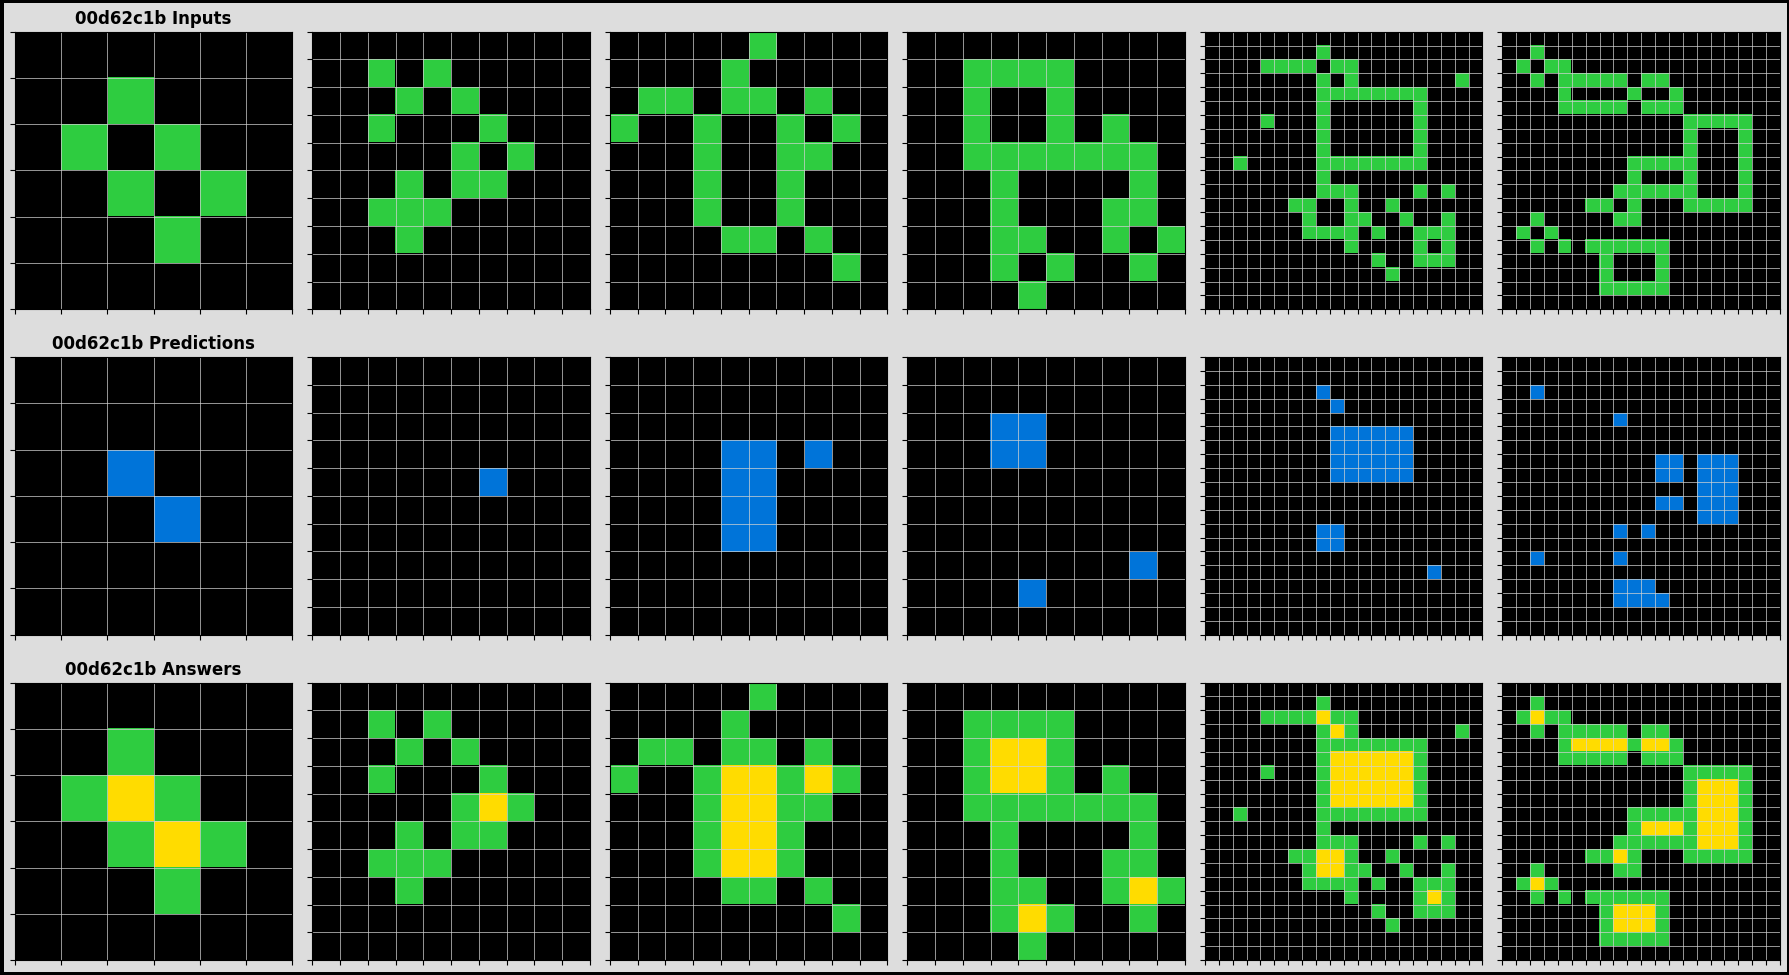

In [9]:
config = load_test_config(ignore_color=True)
test(config)

# Step 2: Consider pixel colors as well

## 2-1. Predict pixels to be kept

In [10]:
class FillerKeepInput(nn.Module):
    def __init__(self, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[128, 32], pad_value=-1, num_classes=10, feature_dim=1, color_dim=1, **kwargs):
        super().__init__()
        self.color_vector = nn.Parameter(torch.randn(num_classes, feature_dim)) # dim-1 because the first channel is the input

        self.attn_input = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=False),
            num_layers=1,
        )

        self.decoder = nn.Sequential(
            nn.Linear(color_dim, 1, bias=False),
        )

    def forward(self, x, **kwargs):
        N, C, H, W = x.shape

        y = self.color_vector.repeat(N*H*W, 1, 1) # [N*H*W, C, V]
        V = y.shape[2]
        y = y.transpose(2, 1) # [N*H*W, V, C]

        x = x.permute(0, 2, 3, 1).reshape(N*H*W, 1, C) # [N*H*W, V, C]
        y = self.attn_input(y, x)
        y = y.transpose(2, 1) # [N*H*W, C, V]

        y = y.reshape(N*H*W*C, V)
        y = self.decoder(y) # [N*H*W*C, 1]
        y = y.view(N, H, W, C).permute(0, 3, 1, 2) # [N, C, H, W]

        return y

data:
  name: FillerKeepInput
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: true
    ignore_color: false
model:
  name: FillerKeepInput
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
    pad_value: -1
    d_conv_feature: 16
    d_color_feature: 32
train:
  name: default
  params:
    max_epochs: 200
    batch_size_max: 8
    lr: 0.01
    save_dir: ./output/
    ckpt_path: null
    epoch: 10
test:
  name: FillerKeepInput
  params:
    model_path: ./output/FillerKeepInput.ckpt
    verbose_single: false
    n_recurrance_feature_extraction: null
save_path: ./output/

FillerKeepInputL(
  (model): FillerKeepInput(
    (attn_input): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=False)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (dropout3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=1, bias=False)
    )
  )
  (loss_fn_source): CrossEntropyLoss()
)

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ FillerKeepInput  │    861 │ train │
│ 1 │ loss_fn_source │ CrossEntropyLoss │      0 │ train │
└───┴────────────────┴──────────────────┴────────┴───────┘

Trainable params: 861                                                                                              
Non-trainable params: 0                                                                                            
Total params: 861                                                                                                  
Total estimated model params size (MB): 0

Output()

Epoch 1 | Train loss: 11.571170 | N Pixels Wrong: 4894

Epoch 2 | Train loss: 10.920023 | N Pixels Wrong: 4586

Epoch 3 | Train loss: 10.271001 | N Pixels Wrong: 1782

Epoch 4 | Train loss: 9.519429 | N Pixels Wrong: 1434

Epoch 5 | Train loss: 8.787537 | N Pixels Wrong: 1541

Epoch 6 | Train loss: 7.882452 | N Pixels Wrong: 1523

Epoch 7 | Train loss: 6.883139 | N Pixels Wrong: 1329

Epoch 8 | Train loss: 5.817832 | N Pixels Wrong: 676

Epoch 9 | Train loss: 4.839519 | N Pixels Wrong: 589

Epoch 10 | Train loss: 4.040998 | N Pixels Wrong: 590

Epoch 11 | Train loss: 3.278059 | N Pixels Wrong: 567

Epoch 12 | Train loss: 3.021792 | N Pixels Wrong: 575

Epoch 13 | Train loss: 2.783849 | N Pixels Wrong: 572

Epoch 14 | Train loss: 2.531472 | N Pixels Wrong: 600

Epoch 15 | Train loss: 2.181362 | N Pixels Wrong: 541

Epoch 16 | Train loss: 2.077980 | N Pixels Wrong: 552

Epoch 17 | Train loss: 2.037041 | N Pixels Wrong: 577

Epoch 18 | Train loss: 2.014780 | N Pixels Wrong: 554

Epoch 19 | Train loss: 1.923522 | N Pixels Wrong: 559

Epoch 20 | Train loss: 1.860276 | N Pixels Wrong: 584

Epoch 21 | Train loss: 1.807409 | N Pixels Wrong: 563

Epoch 22 | Train loss: 1.801130 | N Pixels Wrong: 564

Epoch 23 | Train loss: 1.777685 | N Pixels Wrong: 563

Epoch 24 | Train loss: 1.727690 | N Pixels Wrong: 574

Epoch 25 | Train loss: 1.667061 | N Pixels Wrong: 549

Epoch 26 | Train loss: 1.681908 | N Pixels Wrong: 537

Epoch 27 | Train loss: 1.687411 | N Pixels Wrong: 547

Epoch 28 | Train loss: 1.669018 | N Pixels Wrong: 554

Epoch 29 | Train loss: 1.644752 | N Pixels Wrong: 549

Epoch 30 | Train loss: 1.668756 | N Pixels Wrong: 569

Epoch 31 | Train loss: 1.583811 | N Pixels Wrong: 555

Epoch 32 | Train loss: 1.604014 | N Pixels Wrong: 553

Epoch 33 | Train loss: 1.502940 | N Pixels Wrong: 522

Epoch 34 | Train loss: 1.529226 | N Pixels Wrong: 508

Epoch 35 | Train loss: 1.506935 | N Pixels Wrong: 480

Epoch 36 | Train loss: 1.490160 | N Pixels Wrong: 504

Epoch 37 | Train loss: 1.582285 | N Pixels Wrong: 515

Epoch 38 | Train loss: 1.491601 | N Pixels Wrong: 491

Epoch 39 | Train loss: 1.514276 | N Pixels Wrong: 506

Epoch 40 | Train loss: 1.481687 | N Pixels Wrong: 499

Epoch 41 | Train loss: 1.442557 | N Pixels Wrong: 499

Epoch 42 | Train loss: 1.415588 | N Pixels Wrong: 489

Epoch 43 | Train loss: 1.462097 | N Pixels Wrong: 505

Epoch 44 | Train loss: 1.475038 | N Pixels Wrong: 502

Epoch 45 | Train loss: 1.423297 | N Pixels Wrong: 508

Epoch 46 | Train loss: 1.454181 | N Pixels Wrong: 507

Epoch 47 | Train loss: 1.475657 | N Pixels Wrong: 516

Epoch 48 | Train loss: 1.414820 | N Pixels Wrong: 483

Epoch 49 | Train loss: 1.498312 | N Pixels Wrong: 504

Epoch 50 | Train loss: 1.465723 | N Pixels Wrong: 502

Epoch 51 | Train loss: 1.438373 | N Pixels Wrong: 511

Epoch 52 | Train loss: 1.449900 | N Pixels Wrong: 492

Epoch 53 | Train loss: 1.406766 | N Pixels Wrong: 483

Epoch 54 | Train loss: 1.421571 | N Pixels Wrong: 500

Epoch 55 | Train loss: 1.431332 | N Pixels Wrong: 495

Epoch 56 | Train loss: 1.393017 | N Pixels Wrong: 499

Epoch 57 | Train loss: 1.365101 | N Pixels Wrong: 480

Epoch 58 | Train loss: 1.352591 | N Pixels Wrong: 496

Epoch 59 | Train loss: 1.412019 | N Pixels Wrong: 499

Epoch 60 | Train loss: 1.425040 | N Pixels Wrong: 495

Epoch 61 | Train loss: 1.398116 | N Pixels Wrong: 511

Epoch 62 | Train loss: 1.356816 | N Pixels Wrong: 478

Epoch 63 | Train loss: 1.378882 | N Pixels Wrong: 493

Epoch 64 | Train loss: 1.385293 | N Pixels Wrong: 491

Epoch 65 | Train loss: 1.468696 | N Pixels Wrong: 497

Epoch 66 | Train loss: 1.383752 | N Pixels Wrong: 499

Epoch 67 | Train loss: 1.372102 | N Pixels Wrong: 490

Epoch 68 | Train loss: 1.422083 | N Pixels Wrong: 486

Epoch 69 | Train loss: 1.445864 | N Pixels Wrong: 508

Epoch 70 | Train loss: 1.366871 | N Pixels Wrong: 508

Epoch 71 | Train loss: 1.423557 | N Pixels Wrong: 508

Epoch 72 | Train loss: 1.321210 | N Pixels Wrong: 485

Epoch 73 | Train loss: 1.406672 | N Pixels Wrong: 509

Epoch 74 | Train loss: 1.328167 | N Pixels Wrong: 488

Epoch 75 | Train loss: 1.391530 | N Pixels Wrong: 507

Epoch 76 | Train loss: 1.397678 | N Pixels Wrong: 488

Epoch 77 | Train loss: 1.371257 | N Pixels Wrong: 503

Epoch 78 | Train loss: 1.371027 | N Pixels Wrong: 499

Epoch 79 | Train loss: 1.367567 | N Pixels Wrong: 508

Epoch 80 | Train loss: 1.417700 | N Pixels Wrong: 519

Epoch 81 | Train loss: 1.424646 | N Pixels Wrong: 496

Epoch 82 | Train loss: 1.354543 | N Pixels Wrong: 485

Epoch 83 | Train loss: 1.377807 | N Pixels Wrong: 515

Epoch 84 | Train loss: 1.408856 | N Pixels Wrong: 496

Epoch 85 | Train loss: 1.344040 | N Pixels Wrong: 487

Epoch 86 | Train loss: 1.368653 | N Pixels Wrong: 500

Epoch 87 | Train loss: 1.411385 | N Pixels Wrong: 502

Epoch 88 | Train loss: 1.338159 | N Pixels Wrong: 492

Epoch 89 | Train loss: 1.371227 | N Pixels Wrong: 494

Epoch 90 | Train loss: 1.392568 | N Pixels Wrong: 511

Epoch 91 | Train loss: 1.367240 | N Pixels Wrong: 494

Epoch 92 | Train loss: 1.366794 | N Pixels Wrong: 489

Epoch 93 | Train loss: 1.365120 | N Pixels Wrong: 511

Epoch 94 | Train loss: 1.355766 | N Pixels Wrong: 491

Epoch 95 | Train loss: 1.346386 | N Pixels Wrong: 490

Epoch 96 | Train loss: 1.329973 | N Pixels Wrong: 493

Epoch 97 | Train loss: 1.342275 | N Pixels Wrong: 487

Epoch 98 | Train loss: 1.345585 | N Pixels Wrong: 492

Epoch 99 | Train loss: 1.374321 | N Pixels Wrong: 506

Epoch 100 | Train loss: 1.339152 | N Pixels Wrong: 491

Epoch 101 | Train loss: 1.371647 | N Pixels Wrong: 513

Epoch 102 | Train loss: 1.383121 | N Pixels Wrong: 499

Epoch 103 | Train loss: 1.332176 | N Pixels Wrong: 497

Epoch 104 | Train loss: 1.346859 | N Pixels Wrong: 493

Epoch 105 | Train loss: 1.386421 | N Pixels Wrong: 497

Epoch 106 | Train loss: 1.424676 | N Pixels Wrong: 493

Epoch 107 | Train loss: 1.346169 | N Pixels Wrong: 477

Epoch 108 | Train loss: 1.338478 | N Pixels Wrong: 497

Epoch 109 | Train loss: 1.349727 | N Pixels Wrong: 488

Epoch 110 | Train loss: 1.336123 | N Pixels Wrong: 505

Epoch 111 | Train loss: 1.326523 | N Pixels Wrong: 495

Epoch 112 | Train loss: 1.298284 | N Pixels Wrong: 484

Epoch 113 | Train loss: 1.339370 | N Pixels Wrong: 493

Epoch 114 | Train loss: 1.319782 | N Pixels Wrong: 491

Epoch 115 | Train loss: 1.359514 | N Pixels Wrong: 498

Epoch 116 | Train loss: 1.382445 | N Pixels Wrong: 501

Epoch 117 | Train loss: 1.337858 | N Pixels Wrong: 486

Epoch 118 | Train loss: 1.277395 | N Pixels Wrong: 467

Epoch 119 | Train loss: 1.321880 | N Pixels Wrong: 488

Epoch 120 | Train loss: 1.327554 | N Pixels Wrong: 501

Epoch 121 | Train loss: 1.302449 | N Pixels Wrong: 480

Epoch 122 | Train loss: 1.353053 | N Pixels Wrong: 487

Epoch 123 | Train loss: 1.325780 | N Pixels Wrong: 478

Epoch 124 | Train loss: 1.332173 | N Pixels Wrong: 487

Epoch 125 | Train loss: 1.333695 | N Pixels Wrong: 483

Epoch 126 | Train loss: 1.281529 | N Pixels Wrong: 485

Epoch 127 | Train loss: 1.336404 | N Pixels Wrong: 491

Epoch 128 | Train loss: 1.319874 | N Pixels Wrong: 488

Epoch 129 | Train loss: 1.351569 | N Pixels Wrong: 492

Epoch 130 | Train loss: 1.347662 | N Pixels Wrong: 500

Epoch 131 | Train loss: 1.350172 | N Pixels Wrong: 488

Epoch 132 | Train loss: 1.350600 | N Pixels Wrong: 496

Epoch 133 | Train loss: 1.341036 | N Pixels Wrong: 480

Epoch 134 | Train loss: 1.330240 | N Pixels Wrong: 487

Epoch 135 | Train loss: 1.345705 | N Pixels Wrong: 483

Epoch 136 | Train loss: 1.301368 | N Pixels Wrong: 478

Epoch 137 | Train loss: 1.313331 | N Pixels Wrong: 477

Epoch 138 | Train loss: 1.284182 | N Pixels Wrong: 492

Epoch 139 | Train loss: 1.325358 | N Pixels Wrong: 484

Epoch 140 | Train loss: 1.264263 | N Pixels Wrong: 474

Epoch 141 | Train loss: 1.319683 | N Pixels Wrong: 505

Epoch 142 | Train loss: 1.318874 | N Pixels Wrong: 494

Epoch 143 | Train loss: 1.322598 | N Pixels Wrong: 488

Epoch 144 | Train loss: 1.347065 | N Pixels Wrong: 495

Epoch 145 | Train loss: 1.315173 | N Pixels Wrong: 485

Epoch 146 | Train loss: 1.327410 | N Pixels Wrong: 476

Epoch 147 | Train loss: 1.332811 | N Pixels Wrong: 477

Epoch 148 | Train loss: 1.323254 | N Pixels Wrong: 482

Epoch 149 | Train loss: 1.314535 | N Pixels Wrong: 483

Epoch 150 | Train loss: 1.387156 | N Pixels Wrong: 505

Epoch 151 | Train loss: 1.330542 | N Pixels Wrong: 485

Epoch 152 | Train loss: 1.345564 | N Pixels Wrong: 481

Epoch 153 | Train loss: 1.324197 | N Pixels Wrong: 502

Epoch 154 | Train loss: 1.300005 | N Pixels Wrong: 488

Epoch 155 | Train loss: 1.305956 | N Pixels Wrong: 501

Epoch 156 | Train loss: 1.339994 | N Pixels Wrong: 490

Epoch 157 | Train loss: 1.309823 | N Pixels Wrong: 477

Epoch 158 | Train loss: 1.252668 | N Pixels Wrong: 474

Epoch 159 | Train loss: 1.263307 | N Pixels Wrong: 481

Epoch 160 | Train loss: 1.360523 | N Pixels Wrong: 498

Epoch 161 | Train loss: 1.324154 | N Pixels Wrong: 497

Epoch 162 | Train loss: 1.285249 | N Pixels Wrong: 479

Epoch 163 | Train loss: 1.324364 | N Pixels Wrong: 478

Epoch 164 | Train loss: 1.358951 | N Pixels Wrong: 499

Epoch 165 | Train loss: 1.298986 | N Pixels Wrong: 486

Epoch 166 | Train loss: 1.323081 | N Pixels Wrong: 492

Epoch 167 | Train loss: 1.324896 | N Pixels Wrong: 475

Epoch 168 | Train loss: 1.341374 | N Pixels Wrong: 490

Epoch 169 | Train loss: 1.328637 | N Pixels Wrong: 478

Epoch 170 | Train loss: 1.320429 | N Pixels Wrong: 497

Epoch 171 | Train loss: 1.302111 | N Pixels Wrong: 487

Epoch 172 | Train loss: 1.334782 | N Pixels Wrong: 490

Epoch 173 | Train loss: 1.372014 | N Pixels Wrong: 495

Epoch 174 | Train loss: 1.304845 | N Pixels Wrong: 497

Epoch 175 | Train loss: 1.304802 | N Pixels Wrong: 489

Epoch 176 | Train loss: 1.355523 | N Pixels Wrong: 482

Epoch 177 | Train loss: 1.381593 | N Pixels Wrong: 497

Epoch 178 | Train loss: 1.335145 | N Pixels Wrong: 496

Epoch 179 | Train loss: 1.322550 | N Pixels Wrong: 494

Epoch 180 | Train loss: 1.364420 | N Pixels Wrong: 495

Epoch 181 | Train loss: 1.366273 | N Pixels Wrong: 487

Epoch 182 | Train loss: 1.304736 | N Pixels Wrong: 477

Epoch 183 | Train loss: 1.321917 | N Pixels Wrong: 487

Epoch 184 | Train loss: 1.337881 | N Pixels Wrong: 489

Epoch 185 | Train loss: 1.321806 | N Pixels Wrong: 489

Epoch 186 | Train loss: 1.301835 | N Pixels Wrong: 493

Epoch 187 | Train loss: 1.283493 | N Pixels Wrong: 487

Epoch 188 | Train loss: 1.336260 | N Pixels Wrong: 480

Epoch 189 | Train loss: 1.306235 | N Pixels Wrong: 479

Epoch 190 | Train loss: 1.339869 | N Pixels Wrong: 494

Epoch 191 | Train loss: 1.344768 | N Pixels Wrong: 510

Epoch 192 | Train loss: 1.313511 | N Pixels Wrong: 486

Epoch 193 | Train loss: 1.356309 | N Pixels Wrong: 502

Epoch 194 | Train loss: 1.327940 | N Pixels Wrong: 487

Epoch 195 | Train loss: 1.355604 | N Pixels Wrong: 508

Epoch 196 | Train loss: 1.325211 | N Pixels Wrong: 498

Epoch 197 | Train loss: 1.302880 | N Pixels Wrong: 473

Epoch 198 | Train loss: 1.290012 | N Pixels Wrong: 480

Epoch 199 | Train loss: 1.317818 | N Pixels Wrong: 476

Epoch 200 | Train loss: 1.341077 | N Pixels Wrong: 482

Seed used 4757197137207597799

Model saved to: ./output/FillerKeepInput.ckpt

Task: 00d62c1b | train 1 |  94.44% correct | 2 Pixels Wrong

Task: 00d62c1b | train 2 |  99.00% correct | 1 Pixels Wrong

Task: 00d62c1b | train 3 |  91.00% correct | 9 Pixels Wrong

Task: 00d62c1b | train 4 |  94.00% correct | 6 Pixels Wrong

Task: 00d62c1b | train 5 |  92.25% correct | 31 Pixels Wrong

Task: 00d62c1b |  test 1 |  91.75% correct | 33 Pixels Wrong

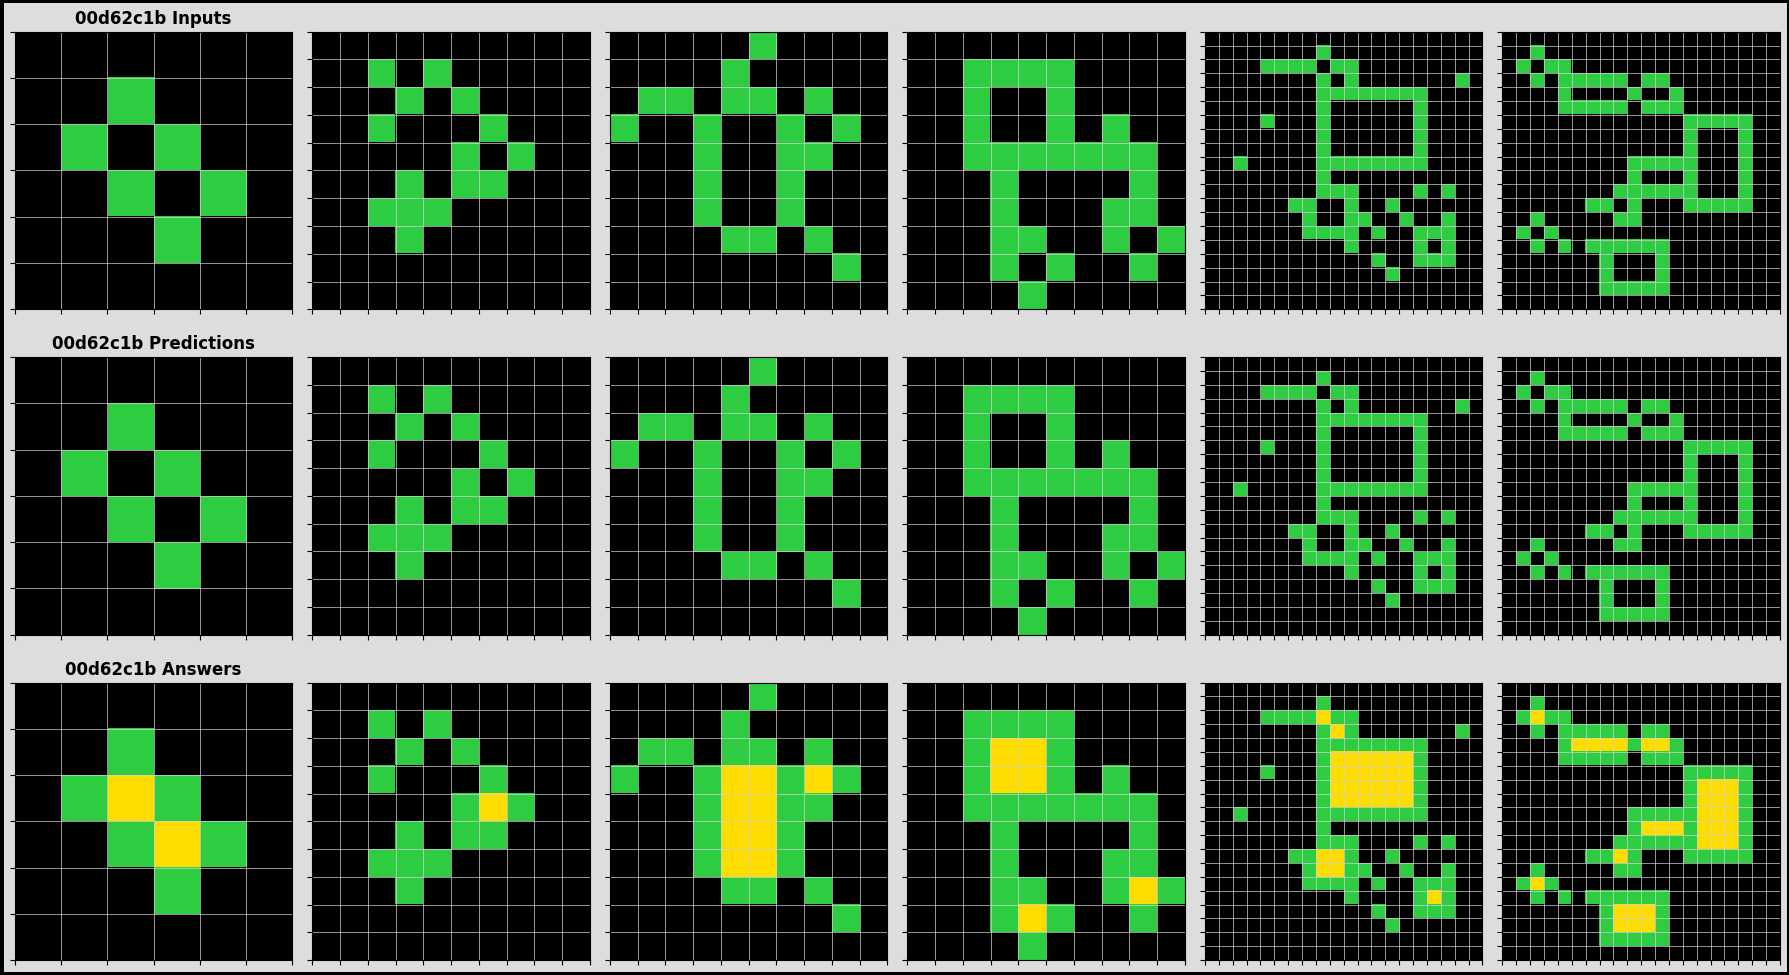

In [11]:
config = load_train_config()
config.train.params.epoch = 10
model = train(config, FillerKeepInput, return_model=True) # Apply custom model

config = load_test_config()
test(config, model)

## 2-2. Predict which pixels to be kept and replaced by which color

### Fast Version with Simple Attention over Recurrence of Convolution Layer's Output

In [12]:
# https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/ch08/attention_seq2seq.py

class AttentionWeight(nn.Module):
    def __init__(self):
        super(AttentionWeight, self).__init__()

    def forward(self, hs, h):
        # hs: batch_size x seq_len x hidden_dim
        # h: batch_size x hidden_dim
        # Expanding h to match hs's dimensions for batch-wise multiplication
        hr = h.unsqueeze(1)  # shape: batch_size x 1 x hidden_dim
        t = hs * hr
        s = torch.sum(t, dim=2)  # Sum across hidden_dim
        a = F.softmax(s, dim=1)  # Apply softmax across seq_len
        return a

class WeightSum(nn.Module):
    def __init__(self):
        super(WeightSum, self).__init__()

    def forward(self, hs, a):
        # hs: batch_size x seq_len x hidden_dim
        # a: batch_size x seq_len
        # Need to expand a for element-wise multiplication
        ar = a.unsqueeze(2)  # shape: batch_size x seq_len x 1
        t = hs * ar
        c = torch.sum(t, dim=1)  # Sum across seq_len
        return c

class ReductiveAttention(nn.Module):
    def __init__(self):
        super(ReductiveAttention, self).__init__()
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()

    def forward(self, hs, h):
        # hs: batch_size x seq_len x hidden_dim
        # h: batch_size x hidden_dim
        a = self.attention_weight_layer(hs, h)
        out = self.weight_sum_layer(hs, a)
        return out

In [13]:
import torch
from torch import nn

from arc_prize.model.components.convfixedkernel import Conv2dEncoderLayer
from arc_prize.model.components.attention import ReductiveAttention


class ConvSameColorFeatureExtractor(nn.Module):
    def __init__(self, pad_value=-1, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[512, 32], hidden_dim=16, out_dim=4):
        super().__init__()
        self.out_dim = out_dim
        self.V = reduced_channels_encoder[-1]
        self.encoder = Conv2dEncoderLayer(1, reduced_channels_encoder, pad_value=pad_value, fixed_kernel=True)
        self.extender = Conv2dEncoderLayer(reduced_channels_encoder[-1], reduced_channels_decoder, pad_value=pad_value)
        self.attn_reduction = ReductiveAttention()
        self.attn_h = nn.Parameter(torch.randn(self.V))
        
        self.decoder = nn.Sequential(
            nn.Linear(self.V, out_dim, bias=True),
        )

    def forward(self, x, n_recurrance_feature_extraction=None):
        N, C, H, W = x.shape
        x = x.transpose(1, 0) # [C, N, H, W]
        n_recurrance_feature_extraction = n_recurrance_feature_extraction or max(H, W)

        x_list = []
        for i, x_c in enumerate(x):
            if not torch.any(x_c == 1):
                x_c = (x_c.view(1, N, 1, H, W) + 1).repeat(1, 1,  self.out_dim, 1, 1) # .fill_(1) # default value is 0
                x_list.append(x_c)
                continue

            x_c = x_c.view(N, 1, H, W)
            x_c = self.encoder(x_c) # [N, V, H, W]

            features_time = []
            features_time.append(x_c.unsqueeze(0))

            for _ in range(n_recurrance_feature_extraction): ### Varialble (Depends on Input Shape)
                x_c = self.extender(x_c) # [N, V, H, W]
                features_time.append(x_c.unsqueeze(0))
            features_time = torch.cat(features_time) # [S, N, V, H, W]

            S, N, V, H, W = features_time.shape
            features_time = features_time.permute(1, 3, 4, 0, 2).reshape(N*H*W, S, V)
            feature = self.attn_reduction(features_time, self.attn_h.repeat(N*H*W, 1))

            x_c = self.decoder(feature)  # [N*H*W, V]
            x_c = x_c.view(N, H, W, self.out_dim).permute(0, 3, 1, 2)
            x_list.append(x_c.unsqueeze(0)) # [1, N, V, H, W]

        x = torch.cat(x_list) # [C, N, V, H, W]
        return x
        
    def to(self, *args, **kwargs):
        self.encoder = self.encoder.to(*args, **kwargs)
        return super().to(*args, **kwargs)


class FillerKeepInput(nn.Module):
    def __init__(self, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[128, 32], pad_value=-1, num_classes=10, d_conv_feature=16, d_color_feature=32):
        super().__init__()
        self.feature_extractor = ConvSameColorFeatureExtractor(pad_value, reduced_channels_encoder, reduced_channels_decoder, out_dim=d_conv_feature)

        self.attn_input = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=False),
            num_layers=1,
        )
        self.attn_feature = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=True),
            num_layers=1,
        )
        self.decoder = nn.Sequential(
            nn.Linear(d_color_feature, 1, bias=False),
        )

        self.color_vector = nn.Parameter(torch.randn(num_classes, d_color_feature)) # Task_specific color vector

    def forward(self, x, n_recurrance_feature_extraction=None):
        N, C, H, W = x.shape
        feature = self.feature_extractor(x, n_recurrance_feature_extraction) # [C, N, V, H, W]
        feature = feature.permute(1, 3, 4, 0, 2).reshape(N*H*W, C, -1) # [N*H*W, C, V]

        y = self.color_vector.repeat(N*H*W, 1, 1)
        V = y.shape[2]
        feature = feature.transpose(2, 1) 

        y = y.transpose(2, 1) # [N*H*W, V, C]
        y = self.attn_feature(y, feature)
        x = x.permute(0, 2, 3, 1).reshape(N*H*W, 1, C).repeat(1, V, 1)
        y = self.attn_input(y, x)
        y = y.transpose(2, 1) # [N*H*W, C, V]

        y = y.reshape(N*H*W*C, V)
        y = self.decoder(y) # [N*H*W*C, 1]
        y = y.view(N, H, W, C).permute(0, 3, 1, 2) # [N, C, H, W]

        return y

    def to(self, *args, **kwargs):
        self.feature_extractor = self.feature_extractor.to(*args, **kwargs)
        return super().to(*args, **kwargs)


In [14]:
config = load_train_config()
config.train.params.epoch = 50
train(config, FillerKeepInput)

data:
  name: FillerKeepInput
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: true
    ignore_color: false
model:
  name: FillerKeepInput
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
    pad_value: -1
    d_conv_feature: 16
    d_color_feature: 32
train:
  name: default
  params:
    max_epochs: 200
    batch_size_max: 8
    lr: 0.01
    save_dir: ./output/
    ckpt_path: null
    epoch: 50
test:
  name: FillerKeepInput
  params:
    model_path: ./output/FillerKeepInput.ckpt
    verbose_single: false
    n_recurrance_feature_extraction: null
save_path: ./output/

FillerKeepInputL(
  (model): FillerKeepInput(
    (feature_extractor): ConvSameColorFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=32, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (attn_reduction): ReductiveAttention(
        (attention_weight_layer): AttentionWeight()
        (weight_sum_layer): WeightSum()
      )
      (decoder): Sequential(
        (0): Linear(in_features=32, out_features=16, bias=True)
      )
    )
    (attn_input): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=False)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (dropout3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (attn_feature): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=True)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (dropout3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=False)
    )
  )
  (loss_fn_source): CrossEntropyLoss()
)

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ FillerKeepInput  │ 29.4 K │ train │
│ 1 │ loss_fn_source │ CrossEntropyLoss │      0 │ train │
└───┴────────────────┴──────────────────┴────────┴───────┘

Trainable params: 29.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 29.4 K                                                                                               
Total estimated model params size (MB): 0

Output()

Epoch 1 | Train loss: 9.272084 | N Pixels Wrong: 4373

Epoch 2 | Train loss: 3.497710 | N Pixels Wrong: 1384

Epoch 3 | Train loss: 1.834689 | N Pixels Wrong: 455

Epoch 4 | Train loss: 1.127443 | N Pixels Wrong: 436

Epoch 5 | Train loss: 0.744633 | N Pixels Wrong: 356

Epoch 6 | Train loss: 0.724885 | N Pixels Wrong: 371

Epoch 7 | Train loss: 0.733768 | N Pixels Wrong: 465

Epoch 8 | Train loss: 0.710207 | N Pixels Wrong: 443

Epoch 9 | Train loss: 0.695723 | N Pixels Wrong: 437

Epoch 10 | Train loss: 0.629997 | N Pixels Wrong: 375

Epoch 11 | Train loss: 0.586107 | N Pixels Wrong: 388

Epoch 12 | Train loss: 0.523116 | N Pixels Wrong: 385

Epoch 13 | Train loss: 0.482812 | N Pixels Wrong: 334

Epoch 14 | Train loss: 0.464832 | N Pixels Wrong: 323

Epoch 15 | Train loss: 0.413161 | N Pixels Wrong: 270

Epoch 16 | Train loss: 0.361389 | N Pixels Wrong: 239

Epoch 17 | Train loss: 0.351916 | N Pixels Wrong: 259

Epoch 18 | Train loss: 0.339750 | N Pixels Wrong: 254

Epoch 19 | Train loss: 0.292927 | N Pixels Wrong: 228

Epoch 20 | Train loss: 0.222009 | N Pixels Wrong: 176

Epoch 21 | Train loss: 0.162006 | N Pixels Wrong: 113

Epoch 22 | Train loss: 0.135877 | N Pixels Wrong: 91

Epoch 23 | Train loss: 0.174029 | N Pixels Wrong: 125

Epoch 24 | Train loss: 0.192879 | N Pixels Wrong: 159

Epoch 25 | Train loss: 0.129917 | N Pixels Wrong: 95

Epoch 26 | Train loss: 0.114859 | N Pixels Wrong: 80

Epoch 27 | Train loss: 0.207654 | N Pixels Wrong: 131

Epoch 28 | Train loss: 0.198480 | N Pixels Wrong: 147

Epoch 29 | Train loss: 0.219562 | N Pixels Wrong: 109

Epoch 30 | Train loss: 0.185634 | N Pixels Wrong: 126

Epoch 31 | Train loss: 0.146368 | N Pixels Wrong: 87

Epoch 32 | Train loss: 0.087992 | N Pixels Wrong: 57

Epoch 33 | Train loss: 0.065475 | N Pixels Wrong: 29

Epoch 34 | Train loss: 0.041278 | N Pixels Wrong: 22

Epoch 35 | Train loss: 0.032952 | N Pixels Wrong: 18

Epoch 36 | Train loss: 0.029782 | N Pixels Wrong: 17

Epoch 37 | Train loss: 0.023542 | N Pixels Wrong: 16

Epoch 38 | Train loss: 0.027942 | N Pixels Wrong: 15

Epoch 39 | Train loss: 0.013052 | N Pixels Wrong: 10

Epoch 40 | Train loss: 0.010000 | N Pixels Wrong: 7

Epoch 41 | Train loss: 0.009335 | N Pixels Wrong: 10

Epoch 42 | Train loss: 0.007472 | N Pixels Wrong: 5

Epoch 43 | Train loss: 0.006772 | N Pixels Wrong: 3

Epoch 44 | Train loss: 0.005145 | N Pixels Wrong: 4

Epoch 45 | Train loss: 0.003644 | N Pixels Wrong: 2

Epoch 46 | Train loss: 0.004492 | N Pixels Wrong: 4

Epoch 47 | Train loss: 0.002848 | N Pixels Wrong: 3

Epoch 48 | Train loss: 0.003944 | N Pixels Wrong: 7

Epoch 49 | Train loss: 0.003649 | N Pixels Wrong: 2

Epoch 50 | Train loss: 0.004506 | N Pixels Wrong: 2

Epoch 51 | Train loss: 0.003858 | N Pixels Wrong: 2

Epoch 52 | Train loss: 0.002242 | N Pixels Wrong: 2

Epoch 53 | Train loss: 0.002495 | N Pixels Wrong: 1

Epoch 54 | Train loss: 0.001473 | N Pixels Wrong: 0

Epoch 55 | Train loss: 0.001533 | N Pixels Wrong: 1

Epoch 56 | Train loss: 0.001550 | N Pixels Wrong: 2

Epoch 57 | Train loss: 0.000999 | N Pixels Wrong: 0

Epoch 58 | Train loss: 0.001267 | N Pixels Wrong: 1

Epoch 59 | Train loss: 0.000977 | N Pixels Wrong: 1

Epoch 60 | Train loss: 0.000909 | N Pixels Wrong: 0

Epoch 61 | Train loss: 0.000637 | N Pixels Wrong: 0

Epoch 62 | Train loss: 0.000726 | N Pixels Wrong: 0

Epoch 63 | Train loss: 0.000657 | N Pixels Wrong: 0

Model saved to: ./output/FillerKeepInput_63ep.ckpt

Epoch 64 | Train loss: 0.000489 | N Pixels Wrong: 0

Epoch 65 | Train loss: 0.000582 | N Pixels Wrong: 0

Epoch 66 | Train loss: 0.000768 | N Pixels Wrong: 1

Epoch 67 | Train loss: 0.000483 | N Pixels Wrong: 0

Epoch 68 | Train loss: 0.000460 | N Pixels Wrong: 0

Epoch 69 | Train loss: 0.000507 | N Pixels Wrong: 0

Epoch 70 | Train loss: 0.000405 | N Pixels Wrong: 0

Model saved to: ./output/FillerKeepInput_70ep.ckpt

Epoch 71 | Train loss: 0.000387 | N Pixels Wrong: 0

Epoch 72 | Train loss: 0.000359 | N Pixels Wrong: 0

Epoch 73 | Train loss: 0.000367 | N Pixels Wrong: 0

Epoch 74 | Train loss: 0.000330 | N Pixels Wrong: 0

Epoch 75 | Train loss: 0.000302 | N Pixels Wrong: 0

Epoch 76 | Train loss: 0.000304 | N Pixels Wrong: 0

Epoch 77 | Train loss: 0.000334 | N Pixels Wrong: 0

Epoch 78 | Train loss: 0.000340 | N Pixels Wrong: 0

Epoch 79 | Train loss: 0.000281 | N Pixels Wrong: 0

Epoch 80 | Train loss: 0.000284 | N Pixels Wrong: 0

Epoch 81 | Train loss: 0.000272 | N Pixels Wrong: 0

Epoch 82 | Train loss: 0.000263 | N Pixels Wrong: 0

Epoch 83 | Train loss: 0.000283 | N Pixels Wrong: 0

Epoch 84 | Train loss: 0.000260 | N Pixels Wrong: 0

Epoch 85 | Train loss: 0.000253 | N Pixels Wrong: 0

Epoch 86 | Train loss: 0.000271 | N Pixels Wrong: 0

Epoch 87 | Train loss: 0.000234 | N Pixels Wrong: 0

Epoch 88 | Train loss: 0.000268 | N Pixels Wrong: 0

Epoch 89 | Train loss: 0.000241 | N Pixels Wrong: 0

Epoch 90 | Train loss: 0.000223 | N Pixels Wrong: 0

Epoch 91 | Train loss: 0.000228 | N Pixels Wrong: 0

Epoch 92 | Train loss: 0.000203 | N Pixels Wrong: 0

Epoch 93 | Train loss: 0.000218 | N Pixels Wrong: 0

Epoch 94 | Train loss: 0.000221 | N Pixels Wrong: 0

Epoch 95 | Train loss: 0.000213 | N Pixels Wrong: 0

Epoch 96 | Train loss: 0.000208 | N Pixels Wrong: 0

Epoch 97 | Train loss: 0.000213 | N Pixels Wrong: 0

Epoch 98 | Train loss: 0.000190 | N Pixels Wrong: 0

Epoch 99 | Train loss: 0.000203 | N Pixels Wrong: 0

Epoch 100 | Train loss: 0.000197 | N Pixels Wrong: 0

Epoch 101 | Train loss: 0.000237 | N Pixels Wrong: 0

Epoch 102 | Train loss: 0.000178 | N Pixels Wrong: 0

Epoch 103 | Train loss: 0.000194 | N Pixels Wrong: 0

Epoch 104 | Train loss: 0.000172 | N Pixels Wrong: 0

Epoch 105 | Train loss: 0.000174 | N Pixels Wrong: 0

Epoch 106 | Train loss: 0.000163 | N Pixels Wrong: 0

Epoch 107 | Train loss: 0.000161 | N Pixels Wrong: 0

Epoch 108 | Train loss: 0.000164 | N Pixels Wrong: 0

Epoch 109 | Train loss: 0.000165 | N Pixels Wrong: 0

Epoch 110 | Train loss: 0.000162 | N Pixels Wrong: 0

Epoch 111 | Train loss: 0.000157 | N Pixels Wrong: 0

Epoch 112 | Train loss: 0.000149 | N Pixels Wrong: 0

Epoch 113 | Train loss: 0.000176 | N Pixels Wrong: 0

Epoch 114 | Train loss: 0.000166 | N Pixels Wrong: 0

Epoch 115 | Train loss: 0.000167 | N Pixels Wrong: 0

Epoch 116 | Train loss: 0.000155 | N Pixels Wrong: 0

Epoch 117 | Train loss: 0.000149 | N Pixels Wrong: 0

Epoch 118 | Train loss: 0.000140 | N Pixels Wrong: 0

Epoch 119 | Train loss: 0.000151 | N Pixels Wrong: 0

Epoch 120 | Train loss: 0.000154 | N Pixels Wrong: 0

Epoch 121 | Train loss: 0.000140 | N Pixels Wrong: 0

Epoch 122 | Train loss: 0.000143 | N Pixels Wrong: 0

Epoch 123 | Train loss: 0.000136 | N Pixels Wrong: 0

Epoch 124 | Train loss: 0.000133 | N Pixels Wrong: 0

Epoch 125 | Train loss: 0.000122 | N Pixels Wrong: 0

Epoch 126 | Train loss: 0.000127 | N Pixels Wrong: 0

Epoch 127 | Train loss: 0.000194 | N Pixels Wrong: 0

Epoch 128 | Train loss: 0.000127 | N Pixels Wrong: 0

Epoch 129 | Train loss: 0.000126 | N Pixels Wrong: 0

Epoch 130 | Train loss: 0.000134 | N Pixels Wrong: 0

Epoch 131 | Train loss: 0.000119 | N Pixels Wrong: 0

Epoch 132 | Train loss: 0.000117 | N Pixels Wrong: 0

Epoch 133 | Train loss: 0.000112 | N Pixels Wrong: 0

Epoch 134 | Train loss: 0.000110 | N Pixels Wrong: 0

Epoch 135 | Train loss: 0.000111 | N Pixels Wrong: 0

Epoch 136 | Train loss: 0.000109 | N Pixels Wrong: 0

Epoch 137 | Train loss: 0.000118 | N Pixels Wrong: 0

Epoch 138 | Train loss: 0.000115 | N Pixels Wrong: 0

Epoch 139 | Train loss: 0.000133 | N Pixels Wrong: 0

Epoch 140 | Train loss: 0.000108 | N Pixels Wrong: 0

Epoch 141 | Train loss: 0.000109 | N Pixels Wrong: 0

Epoch 142 | Train loss: 0.000104 | N Pixels Wrong: 0

Epoch 143 | Train loss: 0.000100 | N Pixels Wrong: 0

Epoch 144 | Train loss: 0.000103 | N Pixels Wrong: 0

Epoch 145 | Train loss: 0.000123 | N Pixels Wrong: 0

Epoch 146 | Train loss: 0.000096 | N Pixels Wrong: 0

Epoch 147 | Train loss: 0.000107 | N Pixels Wrong: 0

Epoch 148 | Train loss: 0.000091 | N Pixels Wrong: 0

Epoch 149 | Train loss: 0.000093 | N Pixels Wrong: 0

Epoch 150 | Train loss: 0.000095 | N Pixels Wrong: 0

Epoch 151 | Train loss: 0.000095 | N Pixels Wrong: 0

Epoch 152 | Train loss: 0.000093 | N Pixels Wrong: 0

Epoch 153 | Train loss: 0.000089 | N Pixels Wrong: 0

Epoch 154 | Train loss: 0.000087 | N Pixels Wrong: 0

Epoch 155 | Train loss: 0.000096 | N Pixels Wrong: 0

Epoch 156 | Train loss: 0.000083 | N Pixels Wrong: 0

Epoch 157 | Train loss: 0.000095 | N Pixels Wrong: 0

Epoch 158 | Train loss: 0.000095 | N Pixels Wrong: 0

Epoch 159 | Train loss: 0.000089 | N Pixels Wrong: 0

Epoch 160 | Train loss: 0.000088 | N Pixels Wrong: 0

Epoch 161 | Train loss: 0.000088 | N Pixels Wrong: 0

Epoch 162 | Train loss: 0.000102 | N Pixels Wrong: 0

Epoch 163 | Train loss: 0.000085 | N Pixels Wrong: 0

Epoch 164 | Train loss: 0.000086 | N Pixels Wrong: 0

Epoch 165 | Train loss: 0.000110 | N Pixels Wrong: 0

Epoch 166 | Train loss: 0.000085 | N Pixels Wrong: 0

Epoch 167 | Train loss: 0.000080 | N Pixels Wrong: 0

Epoch 168 | Train loss: 0.000080 | N Pixels Wrong: 0

Epoch 169 | Train loss: 0.000081 | N Pixels Wrong: 0

Epoch 170 | Train loss: 0.000077 | N Pixels Wrong: 0

Epoch 171 | Train loss: 0.000078 | N Pixels Wrong: 0

Epoch 172 | Train loss: 0.000078 | N Pixels Wrong: 0

Epoch 173 | Train loss: 0.000087 | N Pixels Wrong: 0

Epoch 174 | Train loss: 0.000084 | N Pixels Wrong: 0

Epoch 175 | Train loss: 0.000087 | N Pixels Wrong: 0

Epoch 176 | Train loss: 0.000069 | N Pixels Wrong: 0

Epoch 177 | Train loss: 0.000077 | N Pixels Wrong: 0

Epoch 178 | Train loss: 0.000072 | N Pixels Wrong: 0

Epoch 179 | Train loss: 0.000073 | N Pixels Wrong: 0

Epoch 180 | Train loss: 0.000074 | N Pixels Wrong: 0

Epoch 181 | Train loss: 0.000067 | N Pixels Wrong: 0

Epoch 182 | Train loss: 0.000074 | N Pixels Wrong: 0

Epoch 183 | Train loss: 0.000080 | N Pixels Wrong: 0

Epoch 184 | Train loss: 0.000072 | N Pixels Wrong: 0

Epoch 185 | Train loss: 0.000069 | N Pixels Wrong: 0

Epoch 186 | Train loss: 0.000068 | N Pixels Wrong: 0

Epoch 187 | Train loss: 0.000076 | N Pixels Wrong: 0

Epoch 188 | Train loss: 0.000072 | N Pixels Wrong: 0

Epoch 189 | Train loss: 0.000067 | N Pixels Wrong: 0

Epoch 190 | Train loss: 0.000062 | N Pixels Wrong: 0

Epoch 191 | Train loss: 0.000066 | N Pixels Wrong: 0

Epoch 192 | Train loss: 0.000067 | N Pixels Wrong: 0

Epoch 193 | Train loss: 0.000073 | N Pixels Wrong: 0

Epoch 194 | Train loss: 0.000066 | N Pixels Wrong: 0

Epoch 195 | Train loss: 0.000070 | N Pixels Wrong: 0

Epoch 196 | Train loss: 0.000059 | N Pixels Wrong: 0

Epoch 197 | Train loss: 0.000089 | N Pixels Wrong: 0

Epoch 198 | Train loss: 0.000071 | N Pixels Wrong: 0

Epoch 199 | Train loss: 0.000057 | N Pixels Wrong: 0

Epoch 200 | Train loss: 0.000067 | N Pixels Wrong: 0

Seed used 13113943678230287911

Model saved to: ./output/FillerKeepInput.ckpt

data:
  name: FillerKeepInput
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: false
    ignore_color: false
model:
  name: FillerKeepInput
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
    pad_value: -1
    d_conv_feature: 16
    d_color_feature: 32
test:
  name: FillerKeepInput
  params:
    model_path: ./output/FillerKeepInput.ckpt
    verbose_single: false
    n_recurrance_feature_extraction: null

Task: 00d62c1b | train 1 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 2 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 3 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 4 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 5 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b |  test 1 |  97.00% correct | 12 Pixels Wrong

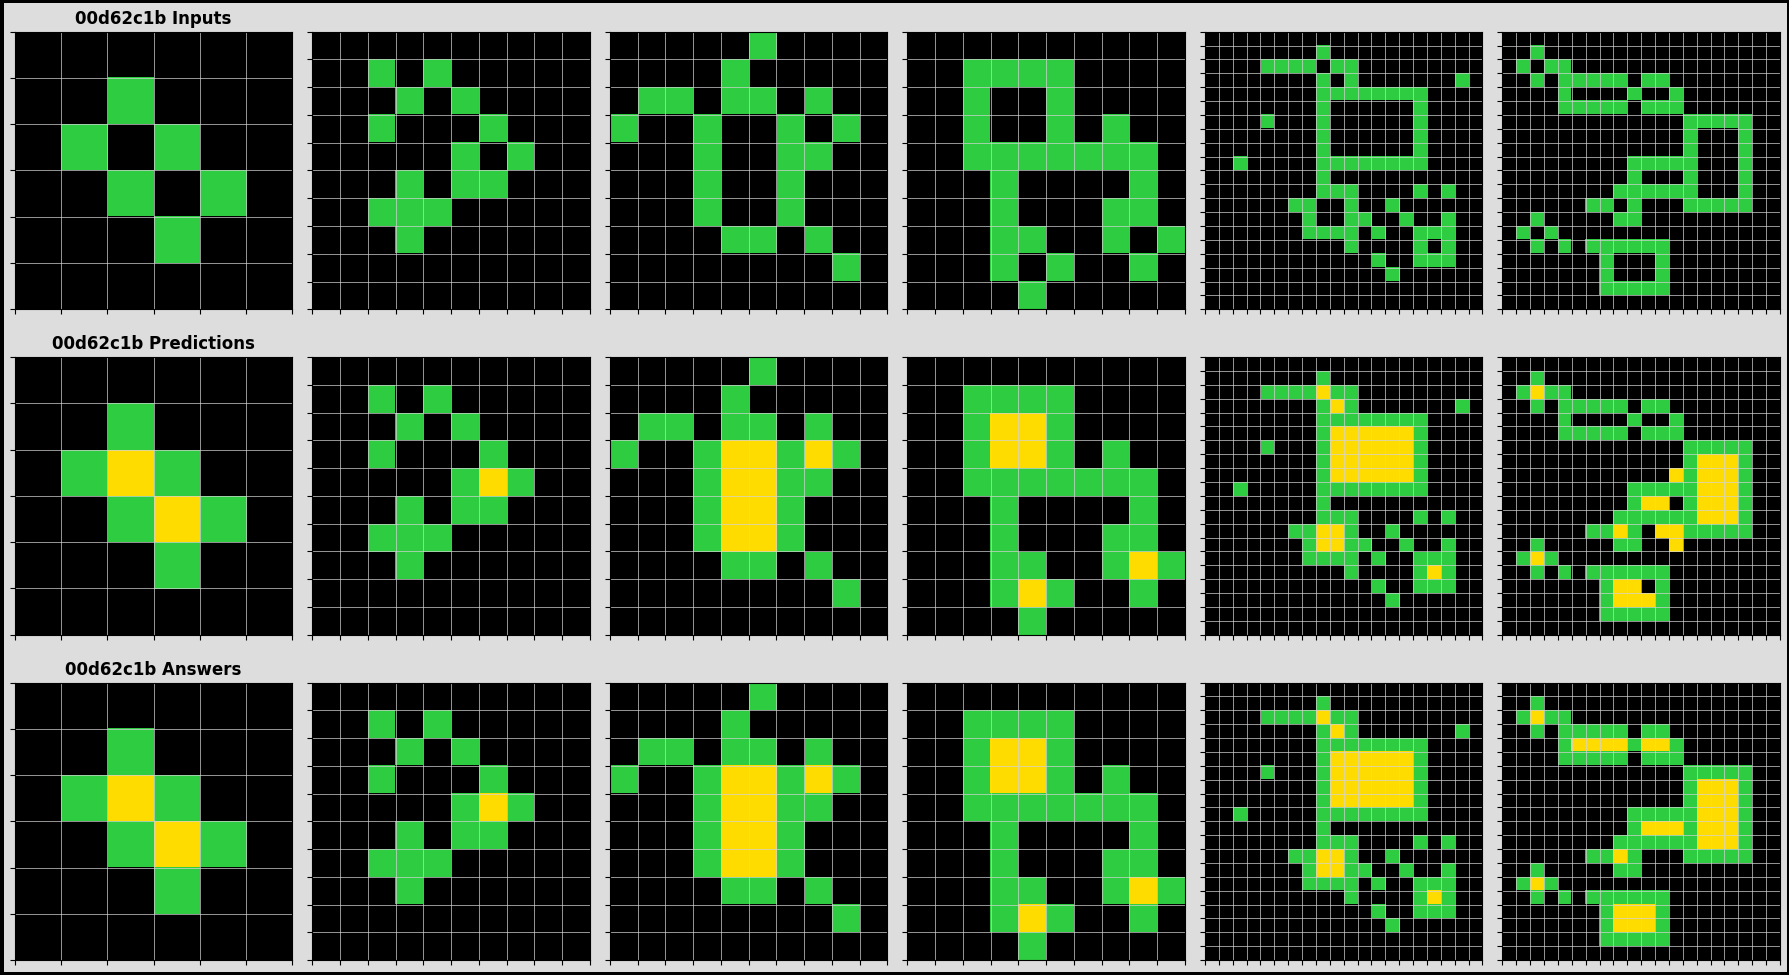

In [15]:
config = load_test_config()
test(config, FillerKeepInput)

### Slow Version with Attentions in Each Recurrence of Convolution Layer's Output (Takes 30 mins)

In [16]:
config = load_train_config()
train(config)

data:
  name: FillerKeepInput
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: true
    ignore_color: false
model:
  name: FillerKeepInput
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
    pad_value: -1
    d_conv_feature: 16
    d_color_feature: 32
train:
  name: default
  params:
    max_epochs: 200
    batch_size_max: 8
    lr: 0.01
    save_dir: ./output/
    ckpt_path: null
test:
  name: FillerKeepInput
  params:
    model_path: ./output/FillerKeepInput.ckpt
    verbose_single: false
    n_recurrance_feature_extraction: null
save_path: ./output/

FillerKeepInputL(
  (model): FillerKeepInput(
    (feature_extractor): ConvSameColorFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=32, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (decoder_initial): Sequential(
        (0): Linear(in_features=32, out_features=16, bias=False)
      )
      (attn_conv): TransformerDecoder(
        (layers): ModuleList(
          (0): TransformerDecoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (multihead_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
            )
            (linear1): Linear(in_features=32, out_features=1, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=1, out_features=32, bias=True)
            (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (norm3): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
            (dropout3): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (decoder_secondary_feature): Sequential(
        (0): Linear(in_features=32, out_features=1, bias=False)
      )
    )
    (attn_input): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=False)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (dropout3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (attn_feature): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=True)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerN

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ FillerKeepInput  │ 38.6 K │ train │
│ 1 │ loss_fn_source │ CrossEntropyLoss │      0 │ train │
└───┴────────────────┴──────────────────┴────────┴───────┘

Trainable params: 38.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 38.6 K                                                                                               
Total estimated model params size (MB): 0

Output()

Epoch 1 | Train loss: 8.826955 | N Pixels Wrong: 2875

Epoch 2 | Train loss: 3.829525 | N Pixels Wrong: 953

Epoch 3 | Train loss: 2.010637 | N Pixels Wrong: 392

Epoch 4 | Train loss: 1.316554 | N Pixels Wrong: 389

Epoch 5 | Train loss: 1.228268 | N Pixels Wrong: 382

Epoch 6 | Train loss: 1.214219 | N Pixels Wrong: 380

Epoch 7 | Train loss: 1.075379 | N Pixels Wrong: 382

Epoch 8 | Train loss: 0.924571 | N Pixels Wrong: 378

Epoch 9 | Train loss: 1.015234 | N Pixels Wrong: 416

Epoch 10 | Train loss: 1.054376 | N Pixels Wrong: 427

Epoch 11 | Train loss: 1.003679 | N Pixels Wrong: 382

Epoch 12 | Train loss: 0.969141 | N Pixels Wrong: 380

Epoch 13 | Train loss: 0.907728 | N Pixels Wrong: 382

Epoch 14 | Train loss: 0.787878 | N Pixels Wrong: 370

Epoch 15 | Train loss: 0.874028 | N Pixels Wrong: 396

Epoch 16 | Train loss: 0.818918 | N Pixels Wrong: 402

Epoch 17 | Train loss: 0.797481 | N Pixels Wrong: 406

Epoch 18 | Train loss: 0.706104 | N Pixels Wrong: 383

Epoch 19 | Train loss: 0.711929 | N Pixels Wrong: 459

Epoch 20 | Train loss: 0.616846 | N Pixels Wrong: 321

Epoch 21 | Train loss: 0.619084 | N Pixels Wrong: 324

Epoch 22 | Train loss: 0.510900 | N Pixels Wrong: 237

Epoch 23 | Train loss: 0.530670 | N Pixels Wrong: 261

Epoch 24 | Train loss: 0.499400 | N Pixels Wrong: 243

Epoch 25 | Train loss: 0.443755 | N Pixels Wrong: 177

Epoch 26 | Train loss: 0.581061 | N Pixels Wrong: 248

Epoch 27 | Train loss: 0.479063 | N Pixels Wrong: 245

Epoch 28 | Train loss: 0.431864 | N Pixels Wrong: 193

Epoch 29 | Train loss: 0.464857 | N Pixels Wrong: 239

Epoch 30 | Train loss: 0.427357 | N Pixels Wrong: 200

Epoch 31 | Train loss: 0.516368 | N Pixels Wrong: 267

Epoch 32 | Train loss: 0.436695 | N Pixels Wrong: 232

Epoch 33 | Train loss: 0.359903 | N Pixels Wrong: 194

Epoch 34 | Train loss: 0.322765 | N Pixels Wrong: 156

Epoch 35 | Train loss: 0.341623 | N Pixels Wrong: 160

Epoch 36 | Train loss: 0.314763 | N Pixels Wrong: 140

Epoch 37 | Train loss: 0.259401 | N Pixels Wrong: 114

Epoch 38 | Train loss: 0.223061 | N Pixels Wrong: 123

Epoch 39 | Train loss: 0.232779 | N Pixels Wrong: 136

Epoch 40 | Train loss: 0.301696 | N Pixels Wrong: 146

Epoch 41 | Train loss: 0.295565 | N Pixels Wrong: 145

Epoch 42 | Train loss: 0.370109 | N Pixels Wrong: 174

Epoch 43 | Train loss: 0.435258 | N Pixels Wrong: 263

Epoch 44 | Train loss: 0.288783 | N Pixels Wrong: 171

Epoch 45 | Train loss: 0.307071 | N Pixels Wrong: 187

Epoch 46 | Train loss: 0.207074 | N Pixels Wrong: 111

Epoch 47 | Train loss: 0.163537 | N Pixels Wrong: 93

Epoch 48 | Train loss: 0.162239 | N Pixels Wrong: 94

Epoch 49 | Train loss: 0.155461 | N Pixels Wrong: 85

Epoch 50 | Train loss: 0.137081 | N Pixels Wrong: 87

Epoch 51 | Train loss: 0.138555 | N Pixels Wrong: 98

Epoch 52 | Train loss: 0.110504 | N Pixels Wrong: 65

Epoch 53 | Train loss: 0.152596 | N Pixels Wrong: 108

Epoch 54 | Train loss: 0.109019 | N Pixels Wrong: 71

Epoch 55 | Train loss: 0.111260 | N Pixels Wrong: 75

Epoch 56 | Train loss: 0.099630 | N Pixels Wrong: 71

Epoch 57 | Train loss: 0.112797 | N Pixels Wrong: 73

Epoch 58 | Train loss: 0.145550 | N Pixels Wrong: 118

Epoch 59 | Train loss: 0.171359 | N Pixels Wrong: 131

Epoch 60 | Train loss: 0.190263 | N Pixels Wrong: 110

Epoch 61 | Train loss: 0.195427 | N Pixels Wrong: 97

Epoch 62 | Train loss: 0.187362 | N Pixels Wrong: 124

Epoch 63 | Train loss: 0.138488 | N Pixels Wrong: 83

Epoch 64 | Train loss: 0.116396 | N Pixels Wrong: 87

Epoch 65 | Train loss: 0.098866 | N Pixels Wrong: 90

Epoch 66 | Train loss: 0.121594 | N Pixels Wrong: 86

Epoch 67 | Train loss: 0.091620 | N Pixels Wrong: 74

Epoch 68 | Train loss: 0.078203 | N Pixels Wrong: 60

Epoch 69 | Train loss: 0.052674 | N Pixels Wrong: 56

Epoch 70 | Train loss: 0.063079 | N Pixels Wrong: 59

Epoch 71 | Train loss: 0.084721 | N Pixels Wrong: 71

Epoch 72 | Train loss: 0.044247 | N Pixels Wrong: 40

Epoch 73 | Train loss: 0.196332 | N Pixels Wrong: 140

Epoch 74 | Train loss: 0.418990 | N Pixels Wrong: 271

Epoch 75 | Train loss: 0.405619 | N Pixels Wrong: 205

Epoch 76 | Train loss: 0.458498 | N Pixels Wrong: 199

Epoch 77 | Train loss: 0.430601 | N Pixels Wrong: 199

Epoch 78 | Train loss: 0.340327 | N Pixels Wrong: 207

Epoch 79 | Train loss: 0.218783 | N Pixels Wrong: 121

Epoch 80 | Train loss: 0.164758 | N Pixels Wrong: 88

Epoch 81 | Train loss: 0.131257 | N Pixels Wrong: 86

Epoch 82 | Train loss: 0.109363 | N Pixels Wrong: 69

Epoch 83 | Train loss: 0.126312 | N Pixels Wrong: 83

Epoch 84 | Train loss: 0.085845 | N Pixels Wrong: 61

Epoch 85 | Train loss: 0.080037 | N Pixels Wrong: 60

Epoch 86 | Train loss: 0.052942 | N Pixels Wrong: 41

Epoch 87 | Train loss: 0.064956 | N Pixels Wrong: 56

Epoch 88 | Train loss: 0.050540 | N Pixels Wrong: 37

Epoch 89 | Train loss: 0.065395 | N Pixels Wrong: 57

Epoch 90 | Train loss: 0.088388 | N Pixels Wrong: 69

Epoch 91 | Train loss: 0.137070 | N Pixels Wrong: 102

Epoch 92 | Train loss: 0.252948 | N Pixels Wrong: 183

Epoch 93 | Train loss: 0.232911 | N Pixels Wrong: 176

Epoch 94 | Train loss: 0.125354 | N Pixels Wrong: 89

Epoch 95 | Train loss: 0.108370 | N Pixels Wrong: 75

Epoch 96 | Train loss: 0.087518 | N Pixels Wrong: 61

Epoch 97 | Train loss: 0.184287 | N Pixels Wrong: 115

Epoch 98 | Train loss: 0.344821 | N Pixels Wrong: 215

Epoch 99 | Train loss: 0.255408 | N Pixels Wrong: 132

Epoch 100 | Train loss: 0.240601 | N Pixels Wrong: 136

Epoch 101 | Train loss: 0.156155 | N Pixels Wrong: 94

Epoch 102 | Train loss: 0.126781 | N Pixels Wrong: 83

Epoch 103 | Train loss: 0.099910 | N Pixels Wrong: 71

Epoch 104 | Train loss: 0.089675 | N Pixels Wrong: 55

Epoch 105 | Train loss: 0.077458 | N Pixels Wrong: 62

Epoch 106 | Train loss: 0.079004 | N Pixels Wrong: 70

Epoch 107 | Train loss: 0.081067 | N Pixels Wrong: 71

Epoch 108 | Train loss: 0.056088 | N Pixels Wrong: 42

Epoch 109 | Train loss: 0.040372 | N Pixels Wrong: 35

Epoch 110 | Train loss: 0.033745 | N Pixels Wrong: 30

Epoch 111 | Train loss: 0.031078 | N Pixels Wrong: 29

Epoch 112 | Train loss: 0.040360 | N Pixels Wrong: 35

Epoch 113 | Train loss: 0.116348 | N Pixels Wrong: 70

Epoch 114 | Train loss: 0.066867 | N Pixels Wrong: 38

Epoch 115 | Train loss: 0.071407 | N Pixels Wrong: 64

Epoch 116 | Train loss: 0.062982 | N Pixels Wrong: 49

Epoch 117 | Train loss: 0.068463 | N Pixels Wrong: 59

Epoch 118 | Train loss: 0.087328 | N Pixels Wrong: 82

Epoch 119 | Train loss: 0.149603 | N Pixels Wrong: 114

Epoch 120 | Train loss: 0.115509 | N Pixels Wrong: 110

Epoch 121 | Train loss: 0.108065 | N Pixels Wrong: 76

Epoch 122 | Train loss: 0.189621 | N Pixels Wrong: 150

Epoch 123 | Train loss: 0.140876 | N Pixels Wrong: 115

Epoch 124 | Train loss: 0.048426 | N Pixels Wrong: 40

Epoch 125 | Train loss: 0.060600 | N Pixels Wrong: 54

Epoch 126 | Train loss: 0.032838 | N Pixels Wrong: 30

Epoch 127 | Train loss: 0.027577 | N Pixels Wrong: 25

Epoch 128 | Train loss: 0.015897 | N Pixels Wrong: 11

Epoch 129 | Train loss: 0.011447 | N Pixels Wrong: 6

Epoch 130 | Train loss: 0.009367 | N Pixels Wrong: 8

Epoch 131 | Train loss: 0.006884 | N Pixels Wrong: 6

Epoch 132 | Train loss: 0.010086 | N Pixels Wrong: 9

Epoch 133 | Train loss: 0.013048 | N Pixels Wrong: 12

Epoch 134 | Train loss: 0.006865 | N Pixels Wrong: 7

Epoch 135 | Train loss: 0.005181 | N Pixels Wrong: 3

Epoch 136 | Train loss: 0.002650 | N Pixels Wrong: 2

Epoch 137 | Train loss: 0.002859 | N Pixels Wrong: 2

Epoch 138 | Train loss: 0.001467 | N Pixels Wrong: 0

Epoch 139 | Train loss: 0.001719 | N Pixels Wrong: 1

Epoch 140 | Train loss: 0.000973 | N Pixels Wrong: 0

Epoch 141 | Train loss: 0.000828 | N Pixels Wrong: 0

Epoch 142 | Train loss: 0.000851 | N Pixels Wrong: 1

Epoch 143 | Train loss: 0.000837 | N Pixels Wrong: 1

Epoch 144 | Train loss: 0.000571 | N Pixels Wrong: 0

Epoch 145 | Train loss: 0.000612 | N Pixels Wrong: 0

Epoch 146 | Train loss: 0.000476 | N Pixels Wrong: 0

Epoch 147 | Train loss: 0.000451 | N Pixels Wrong: 0

Model saved to: ./output/FillerKeepInput_147ep.ckpt

Epoch 148 | Train loss: 0.000403 | N Pixels Wrong: 0

Epoch 149 | Train loss: 0.000390 | N Pixels Wrong: 0

Epoch 150 | Train loss: 0.000346 | N Pixels Wrong: 0

Epoch 151 | Train loss: 0.000362 | N Pixels Wrong: 0

Epoch 152 | Train loss: 0.000327 | N Pixels Wrong: 0

Epoch 153 | Train loss: 0.000304 | N Pixels Wrong: 0

Epoch 154 | Train loss: 0.000301 | N Pixels Wrong: 0

Epoch 155 | Train loss: 0.000277 | N Pixels Wrong: 0

Epoch 156 | Train loss: 0.000257 | N Pixels Wrong: 0

Epoch 157 | Train loss: 0.000292 | N Pixels Wrong: 0

Epoch 158 | Train loss: 0.000258 | N Pixels Wrong: 0

Epoch 159 | Train loss: 0.000284 | N Pixels Wrong: 0

Epoch 160 | Train loss: 0.000249 | N Pixels Wrong: 0

Epoch 161 | Train loss: 0.000240 | N Pixels Wrong: 0

Epoch 162 | Train loss: 0.000218 | N Pixels Wrong: 0

Epoch 163 | Train loss: 0.000230 | N Pixels Wrong: 0

Epoch 164 | Train loss: 0.000208 | N Pixels Wrong: 0

Epoch 165 | Train loss: 0.000197 | N Pixels Wrong: 0

Epoch 166 | Train loss: 0.000208 | N Pixels Wrong: 0

Epoch 167 | Train loss: 0.000190 | N Pixels Wrong: 0

Epoch 168 | Train loss: 0.000191 | N Pixels Wrong: 0

Epoch 169 | Train loss: 0.000238 | N Pixels Wrong: 0

Epoch 170 | Train loss: 0.000219 | N Pixels Wrong: 0

Epoch 171 | Train loss: 0.000183 | N Pixels Wrong: 0

Epoch 172 | Train loss: 0.000180 | N Pixels Wrong: 0

Epoch 173 | Train loss: 0.000177 | N Pixels Wrong: 0

Epoch 174 | Train loss: 0.000165 | N Pixels Wrong: 0

Epoch 175 | Train loss: 0.000169 | N Pixels Wrong: 0

Epoch 176 | Train loss: 0.000164 | N Pixels Wrong: 0

Epoch 177 | Train loss: 0.000167 | N Pixels Wrong: 0

Epoch 178 | Train loss: 0.000159 | N Pixels Wrong: 0

Epoch 179 | Train loss: 0.000145 | N Pixels Wrong: 0

Epoch 180 | Train loss: 0.000147 | N Pixels Wrong: 0

Epoch 181 | Train loss: 0.000134 | N Pixels Wrong: 0

Epoch 182 | Train loss: 0.000135 | N Pixels Wrong: 0

Epoch 183 | Train loss: 0.000144 | N Pixels Wrong: 0

Epoch 184 | Train loss: 0.000136 | N Pixels Wrong: 0

Epoch 185 | Train loss: 0.000140 | N Pixels Wrong: 0

Epoch 186 | Train loss: 0.000133 | N Pixels Wrong: 0

Epoch 187 | Train loss: 0.000133 | N Pixels Wrong: 0

Epoch 188 | Train loss: 0.000131 | N Pixels Wrong: 0

Epoch 189 | Train loss: 0.000137 | N Pixels Wrong: 0

Epoch 190 | Train loss: 0.000132 | N Pixels Wrong: 0

Epoch 191 | Train loss: 0.000120 | N Pixels Wrong: 0

Epoch 192 | Train loss: 0.000113 | N Pixels Wrong: 0

Epoch 193 | Train loss: 0.000127 | N Pixels Wrong: 0

Epoch 194 | Train loss: 0.000124 | N Pixels Wrong: 0

Epoch 195 | Train loss: 0.000118 | N Pixels Wrong: 0

Epoch 196 | Train loss: 0.000121 | N Pixels Wrong: 0

Epoch 197 | Train loss: 0.000117 | N Pixels Wrong: 0

Epoch 198 | Train loss: 0.000117 | N Pixels Wrong: 0

Epoch 199 | Train loss: 0.000116 | N Pixels Wrong: 0

Epoch 200 | Train loss: 0.000109 | N Pixels Wrong: 0

Seed used 1636940048345658935

Model saved to: ./output/FillerKeepInput.ckpt

data:
  name: FillerKeepInput
  params:
    base_path: /kaggle/input/arc-prize-2024/
    cold_value: -1
    augment_data: false
    ignore_color: false
model:
  name: FillerKeepInput
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
    pad_value: -1
    d_conv_feature: 16
    d_color_feature: 32
test:
  name: FillerKeepInput
  params:
    model_path: ./output/FillerKeepInput.ckpt
    verbose_single: false
    n_recurrance_feature_extraction: null

Task: 00d62c1b | train 1 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 2 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 3 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 4 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b | train 5 | 100.00% correct | 0 Pixels Wrong

Task: 00d62c1b |  test 1 |  89.50% correct | 42 Pixels Wrong

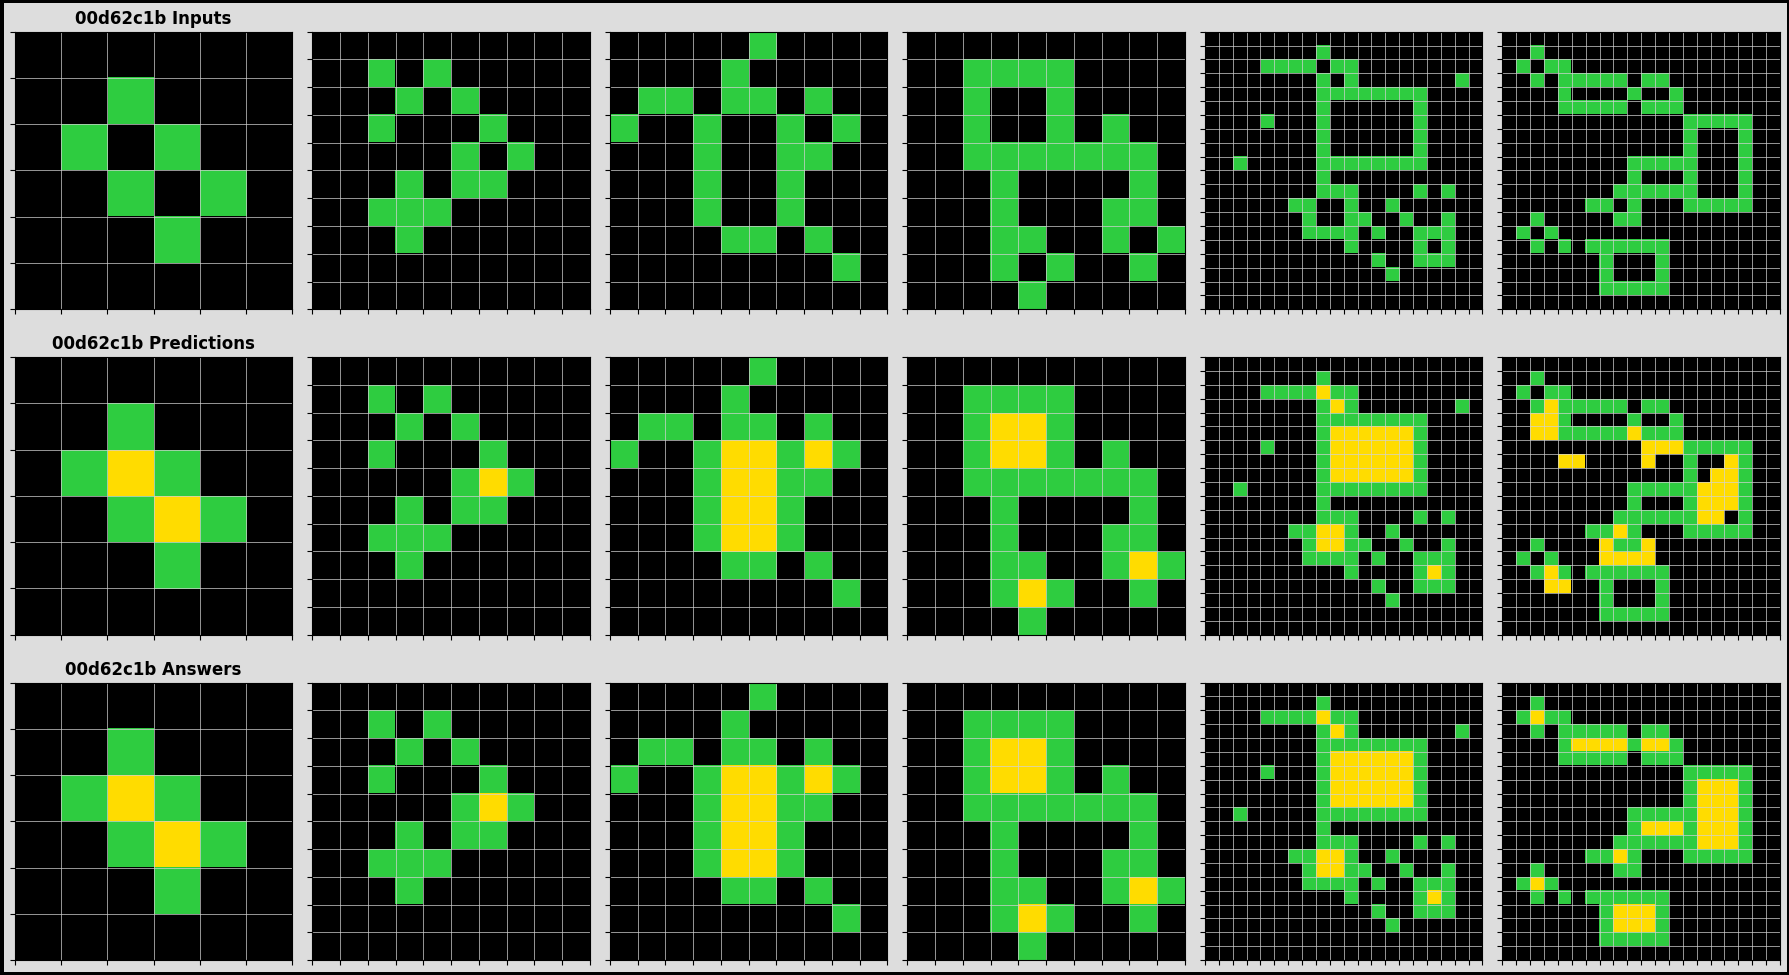

In [17]:
config = load_test_config()
test(config)

# Step 3: Customize the model

## Source Code of the Latest Model

In [18]:
import torch
from torch import nn
import torch.nn.functional as F
from itertools import product
from torch.nn.modules.conv import _size_2_t, Union


class Conv2dFixedKernel(nn.Conv2d):
    def __init__(
        self, 
        in_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = False,
        padding_mode: str = 'zeros',
        device=None,
        dtype=None,
        weight=None, 
        update=False
    ):
        if weight is None:
            weight, out_channels, biases = self.generate_all_possible_NxM_kernels(kernel_size, device=device, dtype=dtype)
        else:
            out_channels = weight.shape[0]
            biases = self.generate_biases(weight)

        super().__init__(
            in_channels, out_channels, 
            kernel_size, stride, padding, dilation, groups, bias, padding_mode, 
            device, dtype
        )

        # Remove the default weight parameter
        del self._parameters['weight']
        del self._parameters['bias']
        
        if update:
            # Register weight as a parameter for updates
            param = nn.Parameter(weight)
            self.register_parameter('weight', param)
            
            self.bias = nn.Parameter(biases, requires_grad=update)
            self.register_parameter('bias', self.bias)
        else:
            # Set fixed weight
            self.weight = weight
            self.bias = biases

    def to(self, *args, **kwargs):
        self.weight = self.weight.to(*args, **kwargs)
        self.bias = self.bias.to(*args, **kwargs)
        return super().to(*args, **kwargs)

    @staticmethod
    def generate_all_possible_NxM_kernels(kernel_size=(3, 3), device=None, dtype=None):
        '''Generate all possible n x m kernels with values 0 and 1'''
        weight_values = [0.0, 1.0]
        repeat = kernel_size[0] * kernel_size[1]
        # Generate all possible combinations of kernel values
        weight_custom = torch.cat(
            [torch.tensor(kernel, dtype=dtype, device=device).reshape(1, 1, kernel_size[0], kernel_size[1]) 
             for kernel in product(weight_values, repeat=repeat)], dim=0)

        out_channels = len(weight_values) ** repeat
        
        # Generate corresponding biases
        biases = -(torch.sum(weight_custom, dim=(2, 3)) - 1).reshape(out_channels).to(device=device, dtype=dtype)
        
        return weight_custom, out_channels, biases

    @staticmethod
    def generate_biases(weight):
        '''Generate biases based on weight patterns'''
        return -(torch.sum(weight, dim=(2, 3)) - 1).reshape(weight.shape[0])


class Conv2dEncoderLayer(nn.Module):
    def __init__(self, in_channels=1, reduced_channels=[512, 32], fixed_kernel=False, out_one_channel=False, kernel_size=(3, 3), stride=1, padding=1, pad_value=-1):
        super().__init__()
        self.padding = padding
        self.pad_value = pad_value
        self.fixed_kernel = fixed_kernel

        if fixed_kernel:
            self.conv = Conv2dFixedKernel(in_channels, kernel_size=kernel_size, stride=stride, padding=0)
        else:
            self.conv = nn.Conv2d(in_channels, reduced_channels[0], kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.activation = nn.ReLU()

        self.linear_layers = nn.Sequential()
        for i in range(len(reduced_channels)-1):
            self.linear_layers.add_module(f'linear_{i}', nn.Linear(reduced_channels[i], reduced_channels[i+1], bias=False))
            self.linear_layers.add_module(f'relu_{i}', nn.ReLU())

        if out_one_channel:
            self.linear_layers.add_module('out', nn.Linear(reduced_channels[-1], 1, bias=False))

        self.norm = nn.InstanceNorm2d(reduced_channels[-1] if not out_one_channel else 1)

    def forward(self, x):
        N, H, W = x.shape[0], x.shape[2], x.shape[3]
        if self.fixed_kernel:
            x = F.pad(x, (self.padding, self.padding, self.padding, self.padding), mode='constant', value=self.pad_value)
        x = self.activation(self.conv(x)) # [N, C, H, W]
        x = x.permute(0, 2, 3, 1).reshape(N*H*W, -1) # [N*H*W, C]
        x = self.linear_layers(x)
        x = x.view(N, H, W, -1).permute(0, 3, 1, 2)
        x = self.norm(x)

        return x

    def to(self, *args, **kwargs):
        self.conv = self.conv.to(*args, **kwargs)
        return super().to(*args, **kwargs)

In [19]:
import torch
from torch import nn

from arc_prize.model.components.convfixedkernel import Conv2dEncoderLayer
from arc_prize.constants import COLORS


class ConvSameColorFeatureExtractor(nn.Module):
    def __init__(self, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[32, 32], d_conv_feature=16, pad_value=-1):
        super().__init__()
        self.d_conv_feature = d_conv_feature
        self.V = reduced_channels_encoder[-1]
        self.encoder = Conv2dEncoderLayer(1, reduced_channels_encoder, pad_value=pad_value, fixed_kernel=True)
        self.extender = Conv2dEncoderLayer(reduced_channels_encoder[-1], reduced_channels_decoder, pad_value=1)
        self.decoder_initial = nn.Sequential(
            nn.Linear(self.V, d_conv_feature, bias=False),
        )

        self.attn_conv = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=self.V, nhead=1, dim_feedforward=1, batch_first=True, bias=True),
            num_layers=1,
        )
        self.decoder_secondary_feature = nn.Sequential(
            nn.Linear(self.V, 1, bias=False),
        )
        self.feature_map = nn.Parameter(torch.randn(d_conv_feature, self.V))

    def forward(self, x, n_recurrance_feature_extraction=None):
        N, C, H, W = x.shape
        V2 = self.d_conv_feature
        x = x.transpose(1, 0) # [C, N, H, W]
        n_recurrance_feature_extraction = n_recurrance_feature_extraction or max(H, W)

        x_list = []
        for i, x_c in enumerate(x):
            if not torch.any(x_c == 1):
                x_c = (x_c.view(1, N, 1, H, W) + 1).repeat(1, 1, V2, 1, 1) # .fill_(1) # default value is 0
                x_list.append(x_c)
                continue

            x_c = x_c.view(N, 1, H, W)
            x_c = self.encoder(x_c) # [N, V, H, W]
            V = x_c.shape[1]

            feature = x_c.permute(0, 2, 3, 1).reshape(N*H*W, self.V)
            feature = self.decoder_initial(feature).view(N*H*W, -1, 1).repeat(1, 1, V) # [N*H*W, V2, V]

            for _ in range(n_recurrance_feature_extraction): ### Varialble (Depends on Input Shape)
                x_c = self.extender(x_c) # [N, V, H, W]

                feature = self.attn_conv(feature, x_c.permute(0, 2, 3, 1).reshape(N*H*W, 1, V))
            feature = feature.view(N, H, W, V2, V).view(N*H*W*V2, V)

            x_c = self.decoder_secondary_feature(feature) # [N*H*W*V2, 1]
            x_c = x_c.view(N, H, W, -1).permute(0, 3, 1, 2)
            x_list.append(x_c.unsqueeze(0)) # [1, N, V, H, W]

        x = torch.cat(x_list) # [C, N, V, H, W]
        return x
        
    def to(self, *args, **kwargs):
        self.encoder = self.encoder.to(*args, **kwargs)
        return super().to(*args, **kwargs)


class FillerKeepInput(nn.Module):
    def __init__(self, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[32, 32], d_conv_feature=16, pad_value=-1, d_color_feature=32, num_classes=len(COLORS)):
        super().__init__()
        self.feature_extractor = ConvSameColorFeatureExtractor(reduced_channels_encoder, reduced_channels_decoder, d_conv_feature, pad_value)
        self.d_color_feature = d_color_feature
    
        self.attn_input = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=False),
            num_layers=1,
        )
        self.attn_feature = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=True),
            num_layers=1,
        )
        self.decoder = nn.Sequential(
            nn.Linear(d_color_feature, 1, bias=False),
        )
        self.color_vector = nn.Parameter(torch.randn(num_classes, d_color_feature)) # Task_specific color vector

    def forward(self, x, n_recurrance_feature_extraction=None):
        N, C, H, W = x.shape
        V = self.d_color_feature
        feature = self.feature_extractor(x, n_recurrance_feature_extraction) # [C, N, V, H, W]
        feature = feature.permute(1, 3, 4, 0, 2).reshape(N*H*W, C, -1) # [N*H*W, C, V]

        y = self.color_vector.repeat(N*H*W, 1, 1)
        feature = feature.transpose(2, 1) # [N*H*W, V, C]

        y = y.transpose(2, 1) # [N*H*W, V, C]
        y = self.attn_feature(y, feature)
        x = x.permute(0, 2, 3, 1).reshape(N*H*W, 1, C)
        y = self.attn_input(y, x)
        y = y.transpose(2, 1) # [N*H*W, C, V]

        y = y.reshape(N*H*W*C, V)
        y = self.decoder(y) # [N*H*W*C, 1]
        y = y.view(N, H, W, C).permute(0, 3, 1, 2) # [N, C, H, W]

        return y

    def to(self, *args, **kwargs):
        self.feature_extractor = self.feature_extractor.to(*args, **kwargs)
        return super().to(*args, **kwargs)

In [20]:
# config = load_train_config()
# train(config, FillerKeepInput, test=True) # Apply custom model